In [1]:
import os
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data import Subset
import torch.optim as optim
import torch.nn.functional as F

In [2]:
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.device_count() # returns 1 in my case


if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

cuda:0
GPU: NVIDIA RTX A6000 is available.


In [ ]:
# === CONFIG ===

CHUNK_SIZE = 16
NUM_FEATURES = 5
NUM_EPOCHS = 50
BATCH_SIZE = 32
K_FOLDS = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# === HELPERS ===
def collate_fn(batch):
    streams, labels = zip(*batch)
    streams = list(zip(*streams))
    streams = [torch.stack(s) for s in streams]
    labels = torch.tensor(labels)
    return streams, labels

def compute_class_weights(labels, device):
    counter = Counter(labels)
    total = sum(counter.values())
    weights = [np.log(total / (counter[i] + 1)) for i in range(len(counter))]
    return torch.tensor(weights, dtype=torch.float).to(device)

def print_model_info(model):
    print("Model Architecture:")
    print(model)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")

def plot_loss_curve(train_losses, val_losses):
    epochs = range(len(train_losses))
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, val_losses, label='Val Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_accuracy_curve(train_acc, val_acc):
    epochs = range(len(train_acc))
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_acc, label='Train Accuracy', color='green')
    plt.plot(epochs, val_acc, label='Val Accuracy', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [5]:
# === DATASET CLASS ===
class MultiStreamDataset(Dataset):
    def __init__(self, data, labels, label_encoder, augment=False):
        self.data = data
        self.labels = label_encoder.transform(labels)
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def augment_stream(self, stream):
        jitter = np.random.normal(0, 0.01, stream.shape)
        scale = np.random.normal(1.0, 0.05, stream.shape)
        return stream * scale + jitter

    def __getitem__(self, idx):
        sample = self.data[idx]
        # if idx == 0:
        #     print("🔍 Raw feature sample:")
        #     print(sample)
        #     print("Min:", sample.min(), "Max:", sample.max())
        streams = [sample[:, i].reshape(1, -1).astype(np.float32) for i in range(sample.shape[1])]
        if self.augment:
            streams = [self.augment_stream(s.copy()) for s in streams]
        streams = [torch.tensor(s).float() for s in streams]
        label = torch.tensor(self.labels[idx])
        return streams, label


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dilation=1, dropout=0.1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=dilation, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=dilation, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        identity = self.downsample(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(self.bn2(self.conv2(out)))
        return F.relu(out + identity)

class MultiStreamCNN(nn.Module):
    def __init__(self, input_length=32, num_classes=12):
        super().__init__()
        self.streams = nn.ModuleList([
            nn.Sequential(
                ResidualBlock(1, 32),
                ResidualBlock(32, 64),
                ResidualBlock(64, 128),
                nn.MaxPool1d(2),
                ResidualBlock(128, 256, dilation=2),
                ResidualBlock(256, 256, dilation=2),
                nn.AdaptiveAvgPool1d(1),
                nn.Flatten()
            ) for _ in range(5)
        ])
        self.fc = nn.Sequential(
            nn.LayerNorm(256 * 5),
            nn.Linear(256 * 5, 512),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),   # ✅ extra
            nn.GELU(),             # ✅ extra
            nn.Linear(128, num_classes)
        )
        self.proj = nn.Linear(256 * 5, 128)  # ✅ New: for feature projection

    def forward(self, streams, return_features=False):
        features = [self.streams[i](streams[i]) for i in range(5)]
        x = torch.cat(features, dim=1)
        logits = self.fc(x)
        if return_features:
            feat_proj = self.proj(x)         # ✅ Project [B, 2048] → [B, 128]
            return logits, feat_proj
        return logits  # ✅ Fix: add this

In [7]:

# === COLLATE FUNCTION ===
def collate_fn(batch):
    streams, labels = zip(*batch)
    streams = list(zip(*streams))
    streams = [torch.stack(s) for s in streams]
    labels = torch.tensor(labels)
    return streams, labels

# === LOAD SPLIT FUNCTION ===
def load_split_from_folder(split_dir, expected_shape):
    X, y = [], []
    for class_name in sorted(os.listdir(split_dir)):
        class_path = os.path.join(split_dir, class_name)
        for fname in sorted(os.listdir(class_path)):
            if fname.endswith(".csv"):
                fpath = os.path.join(class_path, fname)
                chunk = pd.read_csv(fpath, header=None).values
                if chunk.shape == expected_shape:
                    X.append(chunk)
                    y.append(class_name)
    return np.array(X), np.array(y)

In [8]:

# === CLASS WEIGHTING ===
def compute_class_weights(labels, device):
    from collections import Counter
    total = len(labels)
    counts = Counter(labels)
    weights = [np.log(total / (counts[i] + 1)) for i in range(len(counts))]
    return torch.tensor(weights, dtype=torch.float).to(device)

# class_weights_tensor = compute_class_weights(label_encoder.transform(y_train_str), device="cpu")

In [9]:
def train_model(model, train_loader, val_loader, device, epochs=50, lr=0.001,
                class_weights=None, optimizer=None, scheduler=None,
                best_model_path="best_model.pth"):

    print("🔍 Class Weights Tensor:")
    print(class_weights)

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    if optimizer is None:
        optimizer = optim.Adam(model.parameters(), lr=lr)

    model.to(device)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_acc = 0
    printed_shape = False

    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0, 0

        for streams, labels in train_loader:
            streams = [s.to(device) for s in streams]
            labels = labels.to(device)

            if not printed_shape:
                print("🔍 Shape of one stream sample:", streams[0].shape)
                printed_shape = True

            outputs = model(streams)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        train_acc = correct / len(train_loader.dataset)
        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(train_acc)

        # === Validation ===
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for streams, labels in val_loader:
                streams = [s.to(device) for s in streams]
                labels = labels.to(device)

                outputs = model(streams)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()

        val_acc = val_correct / len(val_loader.dataset)
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")

        if scheduler:
            scheduler.step()

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)

    model.load_state_dict(torch.load(best_model_path))
    return train_accuracies, val_accuracies, train_losses, val_losses


In [10]:

# === UTILS ===
def load_split_from_folder(split_dir, expected_shape):
    X, y = [], []
    for class_name in sorted(os.listdir(split_dir)):
        class_path = os.path.join(split_dir, class_name)
        for fname in sorted(os.listdir(class_path)):
            if fname.endswith(".csv"):
                fpath = os.path.join(class_path, fname)
                chunk = pd.read_csv(fpath, header=None).values
                if chunk.shape == expected_shape:
                    X.append(chunk)
                    y.append(class_name)
    return np.array(X), np.array(y)

# # === LOAD DATA FROM FOLDER STRUCTURE ===
# expected_shape = (CHUNK_SIZE, NUM_FEATURES)
# X_train_raw, y_train_raw = load_split_from_folder(os.path.join(INPUT_DIR, "train"), expected_shape)
# X_val_raw, y_val_raw     = load_split_from_folder(os.path.join(INPUT_DIR, "val"), expected_shape)

# # === ENCODE LABELS & APPLY SMOTE ===
# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train_raw)

# X_train_flat = X_train_raw.reshape(X_train_raw.shape[0], -1)
# X_resampled, y_resampled = SMOTE().fit_resample(X_train_flat, y_train_encoded)
# X_train_bal = X_resampled.reshape(-1, CHUNK_SIZE, NUM_FEATURES)
# y_train_str = label_encoder.inverse_transform(y_resampled)

# # === BUILD DATASETS AND LOADERS ===
# train_dataset = MultiStreamDataset(X_train_bal, y_train_str, label_encoder, augment=True)
# val_dataset   = MultiStreamDataset(X_val_raw, y_val_raw, label_encoder, augment=False)

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
# val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# # === CLASS WEIGHTS ===
# class_weights_tensor = compute_class_weights(label_encoder.transform(y_train_str), device)


🚀 Running MultiStreamCNN Teacher for Td=30, Tw=10


/home/ea301b/anaconda3/envs/dl_satang/lib/python3.11/site-packages/torch_lr_finder/lr_finder.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


🔍 Finding optimal learning rate...


 90%|█████████ | 181/200 [00:12<00:01, 14.42it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.94E-04


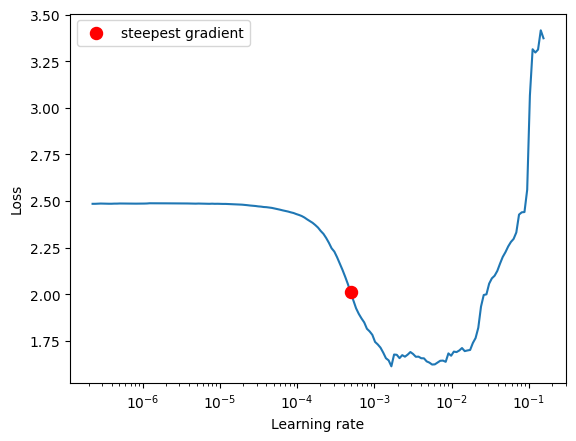

🔍 Class Weights Tensor:
tensor([2.4843, 2.4843, 2.4843, 2.4843, 2.4843, 2.4843, 2.4843, 2.4843, 2.4843,
        2.4843, 2.4843, 2.4843], device='cuda:0')
🔍 Shape of one stream sample: torch.Size([64, 1, 21])
Epoch 1/70 - Train Loss: 0.8685 - Val Loss: 1.5802 - Train Acc: 0.6756 - Val Acc: 0.4785
Epoch 2/70 - Train Loss: 0.6323 - Val Loss: 0.6774 - Train Acc: 0.7666 - Val Acc: 0.7295
Epoch 3/70 - Train Loss: 0.5453 - Val Loss: 0.8726 - Train Acc: 0.8047 - Val Acc: 0.7064
Epoch 4/70 - Train Loss: 0.5040 - Val Loss: 0.7111 - Train Acc: 0.8181 - Val Acc: 0.7199
Epoch 5/70 - Train Loss: 0.4626 - Val Loss: 0.6789 - Train Acc: 0.8315 - Val Acc: 0.7405
Epoch 6/70 - Train Loss: 0.4352 - Val Loss: 0.5497 - Train Acc: 0.8444 - Val Acc: 0.7791
Epoch 7/70 - Train Loss: 0.4177 - Val Loss: 0.5548 - Train Acc: 0.8505 - Val Acc: 0.7610
Epoch 8/70 - Train Loss: 0.3889 - Val Loss: 0.5221 - Train Acc: 0.8582 - Val Acc: 0.7961
Epoch 9/70 - Train Loss: 0.3753 - Val Loss: 0.5603 - Train Acc: 0.8658 - Val Acc

/tmp/ipykernel_1945517/2455991897.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


🔍 Finding optimal learning rate...


 90%|████████▉ | 179/200 [00:10<00:01, 17.27it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.55E-04


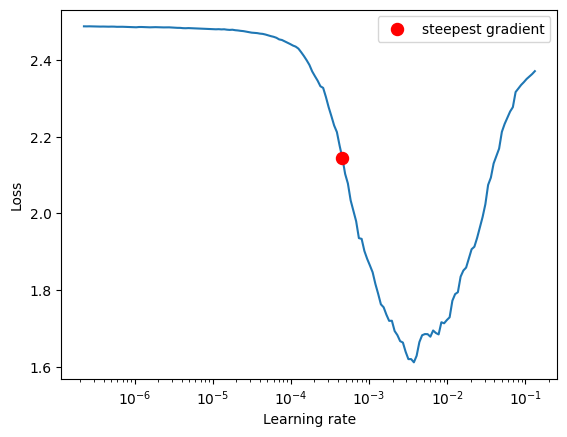

🔍 Class Weights Tensor:
tensor([2.4844, 2.4844, 2.4844, 2.4844, 2.4844, 2.4844, 2.4844, 2.4844, 2.4844,
        2.4844, 2.4844, 2.4844], device='cuda:0')
🔍 Shape of one stream sample: torch.Size([64, 1, 16])
Epoch 1/70 - Train Loss: 0.8805 - Val Loss: 0.7003 - Train Acc: 0.6952 - Val Acc: 0.7335
Epoch 2/70 - Train Loss: 0.5675 - Val Loss: 0.6583 - Train Acc: 0.8042 - Val Acc: 0.7251
Epoch 3/70 - Train Loss: 0.4632 - Val Loss: 0.6607 - Train Acc: 0.8378 - Val Acc: 0.7175
Epoch 4/70 - Train Loss: 0.4193 - Val Loss: 0.5219 - Train Acc: 0.8524 - Val Acc: 0.7995
Epoch 5/70 - Train Loss: 0.3824 - Val Loss: 0.4411 - Train Acc: 0.8695 - Val Acc: 0.8390
Epoch 6/70 - Train Loss: 0.3539 - Val Loss: 0.5022 - Train Acc: 0.8757 - Val Acc: 0.8212
Epoch 7/70 - Train Loss: 0.3386 - Val Loss: 0.5033 - Train Acc: 0.8834 - Val Acc: 0.8140
Epoch 8/70 - Train Loss: 0.3114 - Val Loss: 0.4594 - Train Acc: 0.8932 - Val Acc: 0.8424
Epoch 9/70 - Train Loss: 0.2939 - Val Loss: 0.3717 - Train Acc: 0.8978 - Val Acc

/tmp/ipykernel_1945517/2455991897.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


✅ Model saved to /home/HardDisk/Satang/thesis_proj/Deep_Learning/multi_cnn_5/teacher_Td30_Tw15.pth

🚀 Running MultiStreamCNN Teacher for Td=30, Tw=20
🔍 Finding optimal learning rate...


 94%|█████████▍| 188/200 [00:11<00:00, 16.00it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.02E-03


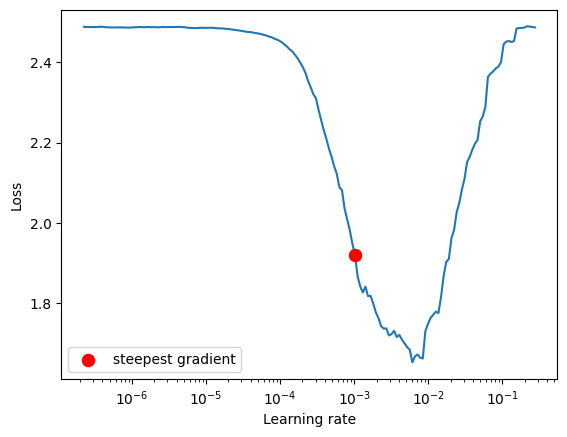

🔍 Class Weights Tensor:
tensor([2.4847, 2.4847, 2.4847, 2.4847, 2.4847, 2.4847, 2.4847, 2.4847, 2.4847,
        2.4847, 2.4847, 2.4847], device='cuda:0')
🔍 Shape of one stream sample: torch.Size([64, 1, 11])
Epoch 1/70 - Train Loss: 0.7955 - Val Loss: 0.7252 - Train Acc: 0.7231 - Val Acc: 0.7325
Epoch 2/70 - Train Loss: 0.5137 - Val Loss: 0.5838 - Train Acc: 0.8186 - Val Acc: 0.7916
Epoch 3/70 - Train Loss: 0.4181 - Val Loss: 0.5817 - Train Acc: 0.8556 - Val Acc: 0.8042
Epoch 4/70 - Train Loss: 0.3717 - Val Loss: 0.4520 - Train Acc: 0.8712 - Val Acc: 0.8384
Epoch 5/70 - Train Loss: 0.3322 - Val Loss: 0.4844 - Train Acc: 0.8851 - Val Acc: 0.8327
Epoch 6/70 - Train Loss: 0.2990 - Val Loss: 0.4029 - Train Acc: 0.8958 - Val Acc: 0.8524
Epoch 7/70 - Train Loss: 0.2835 - Val Loss: 0.4149 - Train Acc: 0.9016 - Val Acc: 0.8507
Epoch 8/70 - Train Loss: 0.2567 - Val Loss: 0.3936 - Train Acc: 0.9099 - Val Acc: 0.8644
Epoch 9/70 - Train Loss: 0.2531 - Val Loss: 0.4091 - Train Acc: 0.9142 - Val Acc

/tmp/ipykernel_1945517/2455991897.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


✅ Model saved to /home/HardDisk/Satang/thesis_proj/Deep_Learning/multi_cnn_5/teacher_Td30_Tw20.pth

🚀 Running MultiStreamCNN Teacher for Td=45, Tw=10
🔍 Finding optimal learning rate...


 90%|█████████ | 180/200 [00:11<00:01, 16.17it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.20E-04


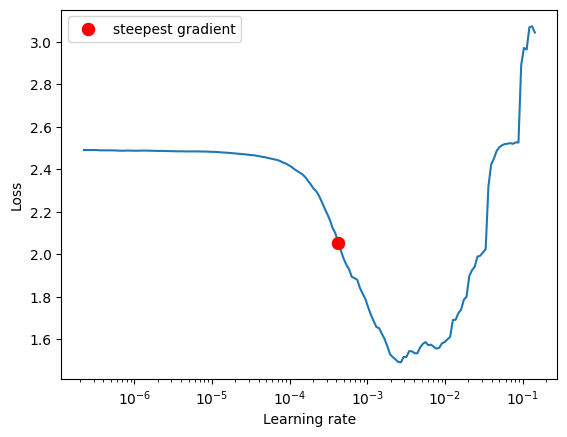

🔍 Class Weights Tensor:
tensor([2.4837, 2.4837, 2.4837, 2.4837, 2.4837, 2.4837, 2.4837, 2.4837, 2.4837,
        2.4837, 2.4837, 2.4837], device='cuda:0')
🔍 Shape of one stream sample: torch.Size([64, 1, 36])
Epoch 1/70 - Train Loss: 0.8317 - Val Loss: 0.7295 - Train Acc: 0.7067 - Val Acc: 0.7209
Epoch 2/70 - Train Loss: 0.4718 - Val Loss: 0.6055 - Train Acc: 0.8352 - Val Acc: 0.7820
Epoch 3/70 - Train Loss: 0.3823 - Val Loss: 0.5943 - Train Acc: 0.8660 - Val Acc: 0.8023
Epoch 4/70 - Train Loss: 0.3338 - Val Loss: 0.4960 - Train Acc: 0.8811 - Val Acc: 0.8333
Epoch 5/70 - Train Loss: 0.3585 - Val Loss: 0.4172 - Train Acc: 0.8910 - Val Acc: 0.8343
Epoch 6/70 - Train Loss: 0.2514 - Val Loss: 0.7823 - Train Acc: 0.9134 - Val Acc: 0.7655
Epoch 7/70 - Train Loss: 0.2526 - Val Loss: 0.3703 - Train Acc: 0.9131 - Val Acc: 0.8837
Epoch 8/70 - Train Loss: 0.2532 - Val Loss: 0.2910 - Train Acc: 0.9133 - Val Acc: 0.8847
Epoch 9/70 - Train Loss: 0.2276 - Val Loss: 0.3361 - Train Acc: 0.9286 - Val Acc

/tmp/ipykernel_1945517/2455991897.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


🔍 Finding optimal learning rate...


 94%|█████████▍| 189/200 [00:11<00:00, 16.27it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.55E-01


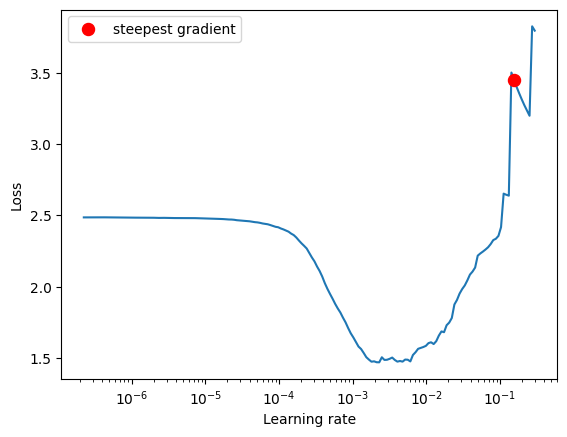

🔍 Class Weights Tensor:
tensor([2.4840, 2.4840, 2.4840, 2.4840, 2.4840, 2.4840, 2.4840, 2.4840, 2.4840,
        2.4840, 2.4840, 2.4840], device='cuda:0')
🔍 Shape of one stream sample: torch.Size([64, 1, 31])
Epoch 1/70 - Train Loss: 0.7956 - Val Loss: 0.5828 - Train Acc: 0.7335 - Val Acc: 0.7619
Epoch 2/70 - Train Loss: 0.4609 - Val Loss: 0.5911 - Train Acc: 0.8419 - Val Acc: 0.7801
Epoch 3/70 - Train Loss: 0.3670 - Val Loss: 0.4406 - Train Acc: 0.8733 - Val Acc: 0.8378
Epoch 4/70 - Train Loss: 0.3099 - Val Loss: 0.5429 - Train Acc: 0.8895 - Val Acc: 0.8342
Epoch 5/70 - Train Loss: 0.2821 - Val Loss: 0.6844 - Train Acc: 0.8997 - Val Acc: 0.7750
Epoch 6/70 - Train Loss: 0.2606 - Val Loss: 0.5175 - Train Acc: 0.9101 - Val Acc: 0.8137
Epoch 7/70 - Train Loss: 0.2443 - Val Loss: 0.3966 - Train Acc: 0.9148 - Val Acc: 0.8612
Epoch 8/70 - Train Loss: 0.2183 - Val Loss: 0.4423 - Train Acc: 0.9281 - Val Acc: 0.8546
Epoch 9/70 - Train Loss: 0.2112 - Val Loss: 0.4153 - Train Acc: 0.9296 - Val Acc

/tmp/ipykernel_1945517/2455991897.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


🔍 Finding optimal learning rate...


 86%|████████▌ | 171/200 [00:10<00:01, 17.01it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.35E-04


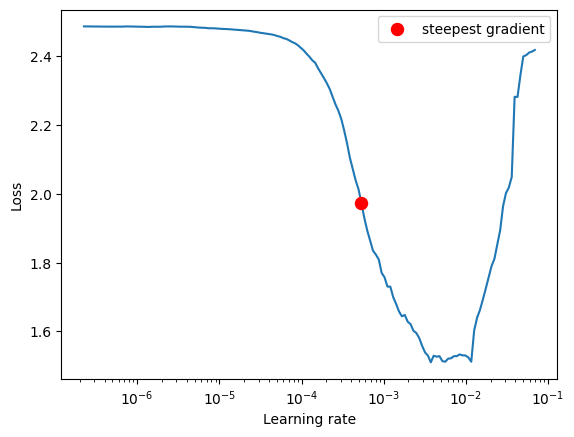

🔍 Class Weights Tensor:
tensor([2.4841, 2.4841, 2.4841, 2.4841, 2.4841, 2.4841, 2.4841, 2.4841, 2.4841,
        2.4841, 2.4841, 2.4841], device='cuda:0')
🔍 Shape of one stream sample: torch.Size([64, 1, 26])
Epoch 1/70 - Train Loss: 0.7999 - Val Loss: 0.7691 - Train Acc: 0.7198 - Val Acc: 0.7293
Epoch 2/70 - Train Loss: 0.4685 - Val Loss: 0.4544 - Train Acc: 0.8357 - Val Acc: 0.8164
Epoch 3/70 - Train Loss: 0.3770 - Val Loss: 0.8605 - Train Acc: 0.8688 - Val Acc: 0.7527
Epoch 4/70 - Train Loss: 0.3263 - Val Loss: 0.5313 - Train Acc: 0.8843 - Val Acc: 0.8019
Epoch 5/70 - Train Loss: 0.2821 - Val Loss: 0.3839 - Train Acc: 0.9045 - Val Acc: 0.8858
Epoch 6/70 - Train Loss: 0.2423 - Val Loss: 0.3453 - Train Acc: 0.9158 - Val Acc: 0.8839
Epoch 7/70 - Train Loss: 0.2246 - Val Loss: 0.3536 - Train Acc: 0.9223 - Val Acc: 0.8801
Epoch 8/70 - Train Loss: 0.2144 - Val Loss: 0.2738 - Train Acc: 0.9298 - Val Acc: 0.9009
Epoch 9/70 - Train Loss: 0.1999 - Val Loss: 0.3737 - Train Acc: 0.9345 - Val Acc

/tmp/ipykernel_1945517/2455991897.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


🔍 Finding optimal learning rate...


 90%|████████▉ | 179/200 [00:10<00:01, 17.07it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.94E-04


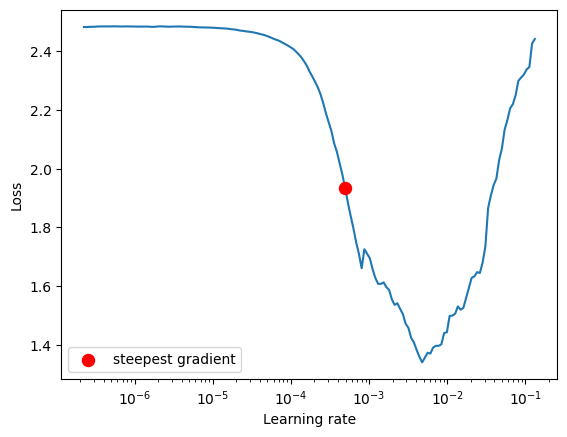

🔍 Class Weights Tensor:
tensor([2.4832, 2.4832, 2.4832, 2.4832, 2.4832, 2.4832, 2.4832, 2.4832, 2.4832,
        2.4832, 2.4832, 2.4832], device='cuda:0')
🔍 Shape of one stream sample: torch.Size([64, 1, 51])
Epoch 1/70 - Train Loss: 0.7994 - Val Loss: 0.7196 - Train Acc: 0.7209 - Val Acc: 0.7249
Epoch 2/70 - Train Loss: 0.4165 - Val Loss: 0.5662 - Train Acc: 0.8550 - Val Acc: 0.7831
Epoch 3/70 - Train Loss: 0.3186 - Val Loss: 0.5969 - Train Acc: 0.8897 - Val Acc: 0.7860
Epoch 4/70 - Train Loss: 0.2959 - Val Loss: 0.5767 - Train Acc: 0.9012 - Val Acc: 0.8180
Epoch 5/70 - Train Loss: 0.2424 - Val Loss: 0.3482 - Train Acc: 0.9186 - Val Acc: 0.9068
Epoch 6/70 - Train Loss: 0.2011 - Val Loss: 0.3772 - Train Acc: 0.9327 - Val Acc: 0.8734
Epoch 7/70 - Train Loss: 0.1917 - Val Loss: 0.3666 - Train Acc: 0.9332 - Val Acc: 0.8792
Epoch 8/70 - Train Loss: 0.1775 - Val Loss: 0.2450 - Train Acc: 0.9403 - Val Acc: 0.9170
Epoch 9/70 - Train Loss: 0.1711 - Val Loss: 0.2848 - Train Acc: 0.9466 - Val Acc

/tmp/ipykernel_1945517/2455991897.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


🔍 Finding optimal learning rate...


 94%|█████████▍| 188/200 [00:11<00:00, 16.99it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.20E-04


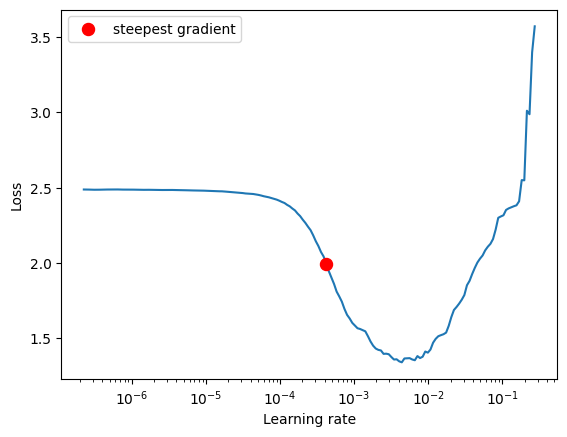

🔍 Class Weights Tensor:
tensor([2.4834, 2.4834, 2.4834, 2.4834, 2.4834, 2.4834, 2.4834, 2.4834, 2.4834,
        2.4834, 2.4834, 2.4834], device='cuda:0')
🔍 Shape of one stream sample: torch.Size([64, 1, 46])
Epoch 1/70 - Train Loss: 0.7650 - Val Loss: 0.5875 - Train Acc: 0.7371 - Val Acc: 0.7848
Epoch 2/70 - Train Loss: 0.3910 - Val Loss: 0.5962 - Train Acc: 0.8596 - Val Acc: 0.7886
Epoch 3/70 - Train Loss: 0.3306 - Val Loss: 0.7742 - Train Acc: 0.8865 - Val Acc: 0.7468
Epoch 4/70 - Train Loss: 0.2439 - Val Loss: 0.3434 - Train Acc: 0.9114 - Val Acc: 0.8835
Epoch 5/70 - Train Loss: 0.2318 - Val Loss: 0.5307 - Train Acc: 0.9172 - Val Acc: 0.7835
Epoch 6/70 - Train Loss: 0.1941 - Val Loss: 0.4771 - Train Acc: 0.9341 - Val Acc: 0.8278
Epoch 7/70 - Train Loss: 0.2010 - Val Loss: 0.3735 - Train Acc: 0.9333 - Val Acc: 0.8671
Epoch 8/70 - Train Loss: 0.1831 - Val Loss: 0.3009 - Train Acc: 0.9397 - Val Acc: 0.9063
Epoch 9/70 - Train Loss: 0.1726 - Val Loss: 0.3322 - Train Acc: 0.9444 - Val Acc

/tmp/ipykernel_1945517/2455991897.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


🔍 Finding optimal learning rate...


 96%|█████████▌| 191/200 [00:11<00:00, 17.10it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.49E-01


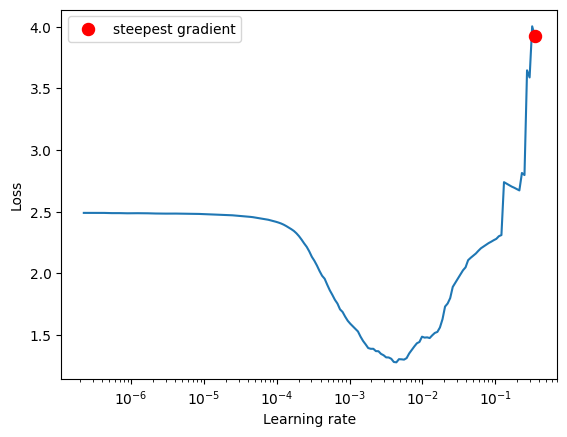

🔍 Class Weights Tensor:
tensor([2.4835, 2.4835, 2.4835, 2.4835, 2.4835, 2.4835, 2.4835, 2.4835, 2.4835,
        2.4835, 2.4835, 2.4835], device='cuda:0')
🔍 Shape of one stream sample: torch.Size([64, 1, 41])
Epoch 1/70 - Train Loss: 0.7638 - Val Loss: 0.7407 - Train Acc: 0.7385 - Val Acc: 0.7377
Epoch 2/70 - Train Loss: 0.4177 - Val Loss: 0.4958 - Train Acc: 0.8539 - Val Acc: 0.8009
Epoch 3/70 - Train Loss: 0.3453 - Val Loss: 0.4636 - Train Acc: 0.8804 - Val Acc: 0.8138
Epoch 4/70 - Train Loss: 0.2799 - Val Loss: 0.4986 - Train Acc: 0.9014 - Val Acc: 0.8162
Epoch 5/70 - Train Loss: 0.2363 - Val Loss: 0.3827 - Train Acc: 0.9202 - Val Acc: 0.8817
Epoch 6/70 - Train Loss: 0.2218 - Val Loss: 0.3834 - Train Acc: 0.9224 - Val Acc: 0.8852
Epoch 7/70 - Train Loss: 0.2015 - Val Loss: 0.3361 - Train Acc: 0.9321 - Val Acc: 0.8981
Epoch 8/70 - Train Loss: 0.1674 - Val Loss: 0.9649 - Train Acc: 0.9450 - Val Acc: 0.7869
Epoch 9/70 - Train Loss: 0.1664 - Val Loss: 0.3499 - Train Acc: 0.9476 - Val Acc

/tmp/ipykernel_1945517/2455991897.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


In [11]:
import os
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from torch.utils.data import DataLoader
from torch_lr_finder import LRFinder

# === Configuration ===
base_dir = "/home/HardDisk/Satang/thesis_proj"
save_root = "/home/HardDisk/Satang/thesis_proj/Deep_Learning/multi_cnn_5"
os.makedirs(save_root, exist_ok=True)

detection_times = [30, 45, 60]
window_sizes = [10, 15, 20]
NUM_EPOCHS = 50
BATCH_SIZE = 64
NUM_FEATURES = 5  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Loop through all combinations ===
for T_d in detection_times:
    for T_w in window_sizes:
        print(f"\n🚀 Running MultiStreamCNN Teacher for Td={T_d}, Tw={T_w}")
        T_len = T_d - T_w + 1
        expected_shape = (T_len, NUM_FEATURES)
        folder_name = f"X_csv_split_{T_len}"
        input_dir = os.path.join(base_dir, f"New_{T_d}", f"{T_w}", "split_tws_5", folder_name)
        train_path = os.path.join(input_dir, "train")
        val_path   = os.path.join(input_dir, "val")
        model_path = os.path.join(save_root, f"teacher_Td{T_d}_Tw{T_w}.pth")

        # === 1. Load Data ===
        X_train_raw, y_train_raw = load_split_from_folder(train_path, expected_shape)
        X_val_raw, y_val_raw     = load_split_from_folder(val_path, expected_shape)

        # === 2. SMOTE Balancing ===
        label_encoder = LabelEncoder()
        y_train_encoded = label_encoder.fit_transform(y_train_raw)
        X_train_flat = X_train_raw.reshape(X_train_raw.shape[0], -1)
        X_resampled, y_resampled = SMOTE().fit_resample(X_train_flat, y_train_encoded)
        X_train_bal = X_resampled.reshape(-1, T_len, NUM_FEATURES)
        y_train_str = label_encoder.inverse_transform(y_resampled)

        # === 3. Dataset & Loader ===
        train_dataset = MultiStreamDataset(X_train_bal, y_train_str, label_encoder, augment=True)
        val_dataset   = MultiStreamDataset(X_val_raw, y_val_raw, label_encoder, augment=False)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

        # === 4. Class Weights ===
        class_weights_tensor = compute_class_weights(label_encoder.transform(y_train_str), device)
        # === 5. LR Finder ===
        print("🔍 Finding optimal learning rate...")
        model_for_lr = MultiStreamCNN(input_length=T_len, num_classes=len(label_encoder.classes_)).to(device)
        optimizer = torch.optim.AdamW(model_for_lr.parameters(), lr=1e-7, weight_decay=1e-4)
        criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
        lr_finder = LRFinder(model_for_lr, optimizer, criterion, device=device)
        lr_finder.range_test(train_loader, end_lr=1, num_iter=200)
        lr_finder.plot()
        lr_finder.reset()

        # === Choose LR Manually After Inspecting Plot ===
        BEST_LR = 0.001  # Replace with best LR found from the plot

        # === 6. Train Final Teacher ===
        final_teacher = MultiStreamCNN(input_length=T_len, num_classes=len(label_encoder.classes_)).to(device)
        optimizer = torch.optim.AdamW(final_teacher.parameters(), lr=BEST_LR, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

        train_accs, val_accs, train_losses, val_losses = train_model(
            model=final_teacher,
            train_loader=train_loader,
            val_loader=val_loader,
            device=device,
            epochs=NUM_EPOCHS,
            class_weights=class_weights_tensor,
            lr=BEST_LR,
            optimizer=optimizer,
            scheduler=scheduler,
            best_model_path=model_path
        )

        print(f"✅ Model saved to {model_path}")


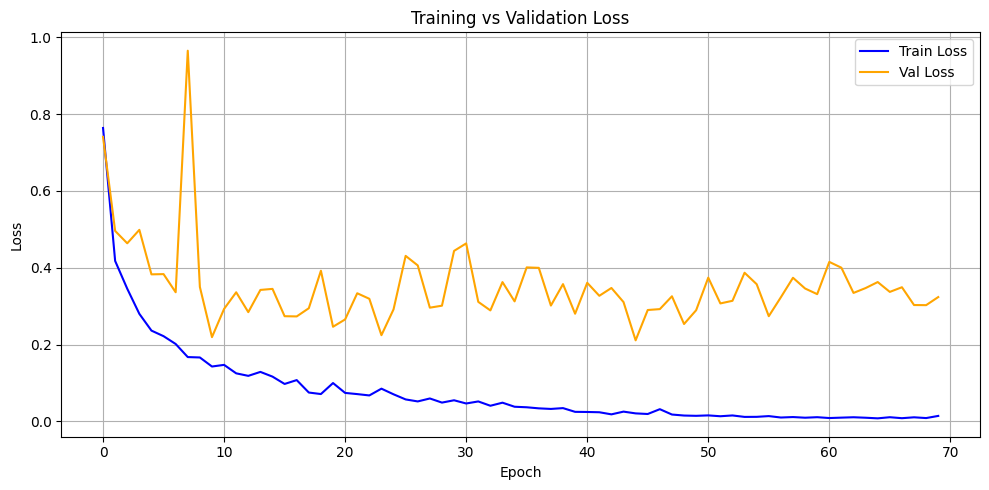

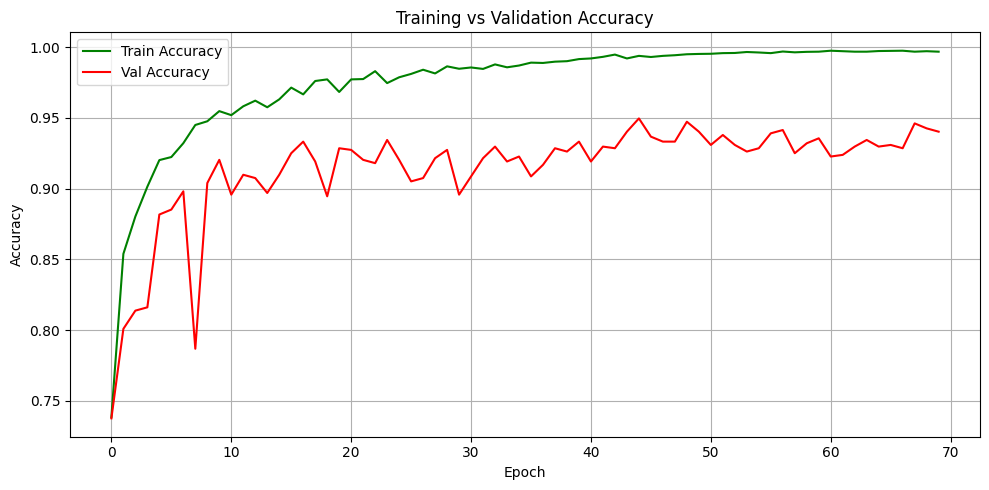

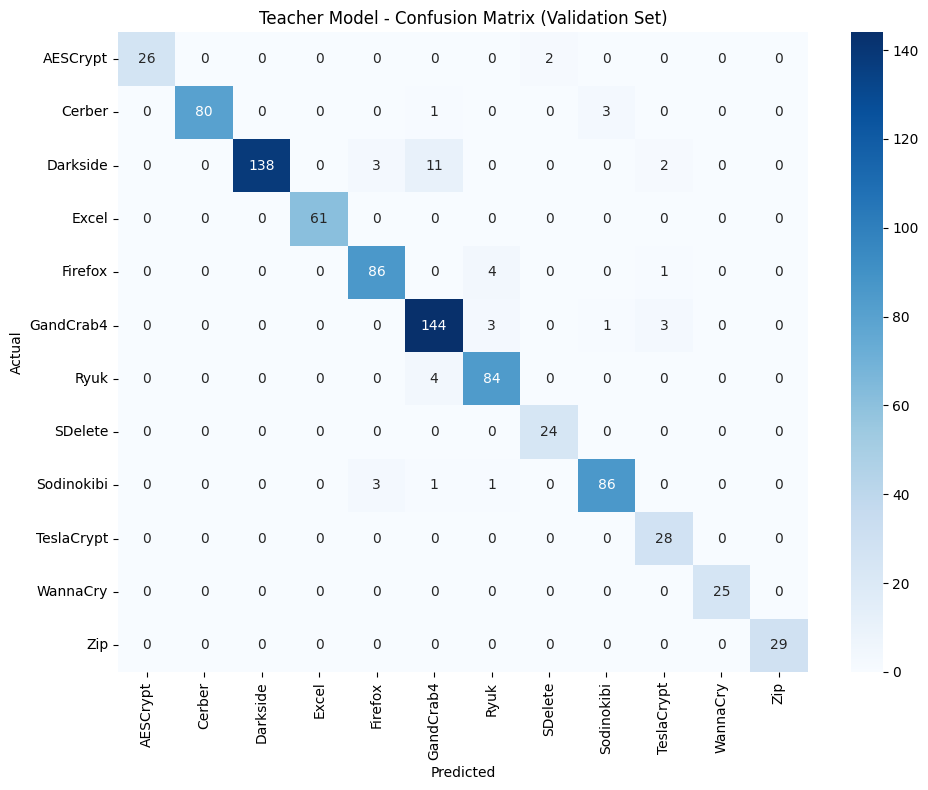


Final Classification Report (Teacher):

              precision    recall  f1-score   support

    AESCrypt       1.00      0.93      0.96        28
      Cerber       1.00      0.95      0.98        84
    Darkside       1.00      0.90      0.95       154
       Excel       1.00      1.00      1.00        61
     Firefox       0.93      0.95      0.94        91
   GandCrab4       0.89      0.95      0.92       151
        Ryuk       0.91      0.95      0.93        88
     SDelete       0.92      1.00      0.96        24
  Sodinokibi       0.96      0.95      0.95        91
  TeslaCrypt       0.82      1.00      0.90        28
    WannaCry       1.00      1.00      1.00        25
         Zip       1.00      1.00      1.00        29

    accuracy                           0.95       854
   macro avg       0.95      0.96      0.96       854
weighted avg       0.95      0.95      0.95       854


Final Training Accuracy: 0.9968
Final Validation Accuracy: 0.9403


In [12]:
# === 🔍 Plot training curves
plot_loss_curve(train_losses, val_losses)
plot_accuracy_curve(train_accs, val_accs)

# === 📊 Evaluate on validation set (same used during training)
final_teacher.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for streams, labels in val_loader:
        streams = [s.to(device) for s in streams]
        labels = labels.to(device)
        outputs = final_teacher(streams)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# === Confusion Matrix & Report
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Teacher Model - Confusion Matrix (Validation Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

print("\nFinal Classification Report (Teacher):\n")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

print(f"\nFinal Training Accuracy: {train_accs[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accs[-1]:.4f}")

🧠 Multi-class AUC (macro): 0.9983


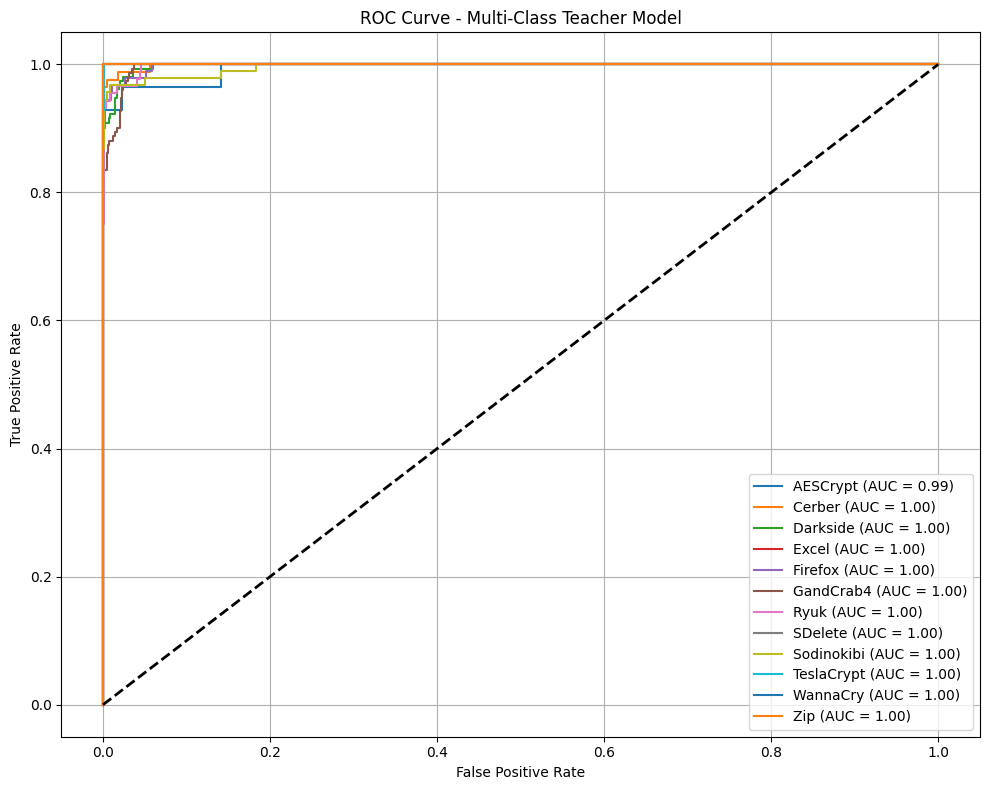

In [13]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# === 1. Get predictions on validation set ===
final_teacher.eval()
y_true = []
y_probs = []

with torch.no_grad():
    for streams, labels in val_loader:
        streams = [s.to(device) for s in streams]
        labels = labels.cpu().numpy()
        outputs = final_teacher(streams)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        
        y_probs.extend(probs)
        y_true.extend(labels)

y_true = np.array(y_true)
y_probs = np.array(y_probs)

# === 2. Binarize labels for ROC AUC ===
y_true_bin = label_binarize(y_true, classes=range(len(label_encoder.classes_)))

# === 3. Compute AUC score (macro-average) ===
auc_macro = roc_auc_score(y_true_bin, y_probs, average="macro", multi_class="ovr")
print(f"🧠 Multi-class AUC (macro): {auc_macro:.4f}")

# === 4. Plot ROC curves per class ===
plt.figure(figsize=(10, 8))
for i in range(len(label_encoder.classes_)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label_encoder.classes_[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multi-Class Teacher Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


### Lightweight measure

In [14]:
import torch
import torch.nn as nn
import time
import os
import psutil
import copy
from thop import profile

# === Profiling functions using clean model copies ===
def get_stream_macs_params(stream, CHUNK_SIZE):
    dummy_input = torch.randn(1, 1, CHUNK_SIZE)
    stream_copy = copy.deepcopy(stream)
    macs, params = profile(stream_copy, inputs=(dummy_input,), verbose=False)
    return macs, params

def get_linear_macs_params(layer, in_features):
    dummy_input = torch.randn(1, in_features)
    layer_copy = copy.deepcopy(layer)
    macs, params = profile(layer_copy, inputs=(dummy_input,), verbose=False)
    return macs, params

# === Utility functions ===
def get_model_size(model):
    temp_path = "temp_model.pth"
    torch.save(model.state_dict(), temp_path)
    size_mb = os.path.getsize(temp_path) / (1024 ** 2)
    os.remove(temp_path)
    return size_mb

def measure_latency(model, inputs, n_runs=100):
    model.eval()
    with torch.no_grad():
        start = time.time()
        for _ in range(n_runs):
            model(inputs)
        end = time.time()
    return (end - start) / n_runs * 1000

def measure_cpu_usage(model, inputs, duration=2):
    model.eval()
    process = psutil.Process(os.getpid())
    num_cpus = psutil.cpu_count(logical=True)
    _ = process.cpu_percent(interval=None)
    with torch.no_grad():
        start_time = time.time()
        while time.time() - start_time < duration:
            model(inputs)
    total_cpu_percent = process.cpu_percent(interval=None)
    return total_cpu_percent / num_cpus

# === Final evaluation logic ===
def evaluate_full_model(model_class, model_path, input_length, *args, **kwargs):
    # 🔁 Load profiling and clean model instances
    prof_model = model_class(input_length=input_length, *args, **kwargs)
    prof_model.load_state_dict(torch.load(model_path))
    prof_model.eval()

    clean_model = model_class(input_length=input_length, *args, **kwargs)
    clean_model.load_state_dict(torch.load(model_path))
    clean_model.eval()

    total_macs, total_params = 0, 0

    print("🔍 Stream MAC breakdown:")
    for i in range(8):
        macs_i, params_i = get_stream_macs_params(prof_model.streams[i], input_length)
        print(f"  Stream[{i}] MACs: {macs_i}, Params: {params_i}")
        total_macs += macs_i
        total_params += params_i

    # FC block
    print("\n🔍 FC Layer breakdown:")
    fc0, fc3, fc6, fc8, fc9 = prof_model.fc[1], prof_model.fc[4], prof_model.fc[7], prof_model.fc[8], prof_model.fc[9]
    macs_fc0, params_fc0 = get_linear_macs_params(fc0, in_features=2048)
    macs_fc3, params_fc3 = get_linear_macs_params(fc3, in_features=512)
    macs_fc6, params_fc6 = get_linear_macs_params(fc6, in_features=256)
    macs_fc8, params_fc8 = get_linear_macs_params(fc8, in_features=128)
    total_macs += macs_fc0 + macs_fc3 + macs_fc6 + macs_fc8
    total_params += params_fc0 + params_fc3 + params_fc6 + params_fc8
    print(f"  FC[0] (2048→512):  {macs_fc0}, Params: {params_fc0}")
    print(f"  FC[3] (512→256):  {macs_fc3}, Params: {params_fc3}")
    print(f"  FC[6] (256→128):  {macs_fc6}, Params: {params_fc6}")
    print(f"  FC[8] (128→classes): {macs_fc8}, Params: {params_fc8}")

    # Projection
    print("\n🔍 Projection Layer:")
    macs_proj, params_proj = get_linear_macs_params(prof_model.proj, in_features=2048)
    total_macs += macs_proj
    total_params += params_proj
    print(f"  Proj (2048→128): {macs_proj}, Params: {params_proj}")

    flops = 2 * total_macs
    size_mb = get_model_size(clean_model)

    dummy_inputs = [torch.randn(1, 1, input_length) for _ in range(8)]
    latency = measure_latency(clean_model, dummy_inputs)
    cpu_usage = measure_cpu_usage(clean_model, dummy_inputs)

    return {
        "Model Size (MB)": round(size_mb, 4),
        "Latency (ms)": round(latency, 3),
        "CPU Usage (%)": round(cpu_usage, 2),
        "Total MACs": int(total_macs),
        "FLOPs": int(flops),
        "Total Params": int(total_params)
    }

# === Usage ===
# You must define your StudentCNN class and load the model first
model = MultiStreamCNN(input_length=CHUNK_SIZE, num_classes=len(label_encoder.classes_))
model.load_state_dict(torch.load("teacher_full.pth"))
# Then:
#torch.save(model.state_dict(), "student_model.pth")
stats = evaluate_full_model(MultiStreamCNN, "teacher_full.pth", input_length=CHUNK_SIZE, num_classes=len(label_encoder.classes_))
for k, v in stats.items():
    print(f"{k}: {v}")


/tmp/ipykernel_1945517/3605911462.py:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("teacher_full.pth"))


FileNotFoundError: [Errno 2] No such file or directory: 'teacher_full.pth'

/tmp/ipykernel_3245880/3475220102.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("teacher_full.pth"))


=== 🧪 Final Test Set Classification Report ===
              precision    recall  f1-score   support

    AESCrypt     1.0000    0.9464    0.9725       112
      Cerber     0.9916    0.9673    0.9793       245
    Darkside     0.9822    0.9085    0.9439       426
       Excel     1.0000    1.0000    1.0000       249
     Firefox     0.9736    0.9847    0.9791       262
   GandCrab4     0.8430    0.9577    0.8967       426
        Ryuk     0.9108    0.9142    0.9125       268
     SDelete     0.9487    1.0000    0.9737       111
  Sodinokibi     0.9480    0.8778    0.9115       270
  TeslaCrypt     0.9161    0.8912    0.9034       147
    WannaCry     1.0000    1.0000    1.0000       128
         Zip     1.0000    1.0000    1.0000       113

    accuracy                         0.9467      2757
   macro avg     0.9595    0.9540    0.9561      2757
weighted avg     0.9494    0.9467    0.9471      2757



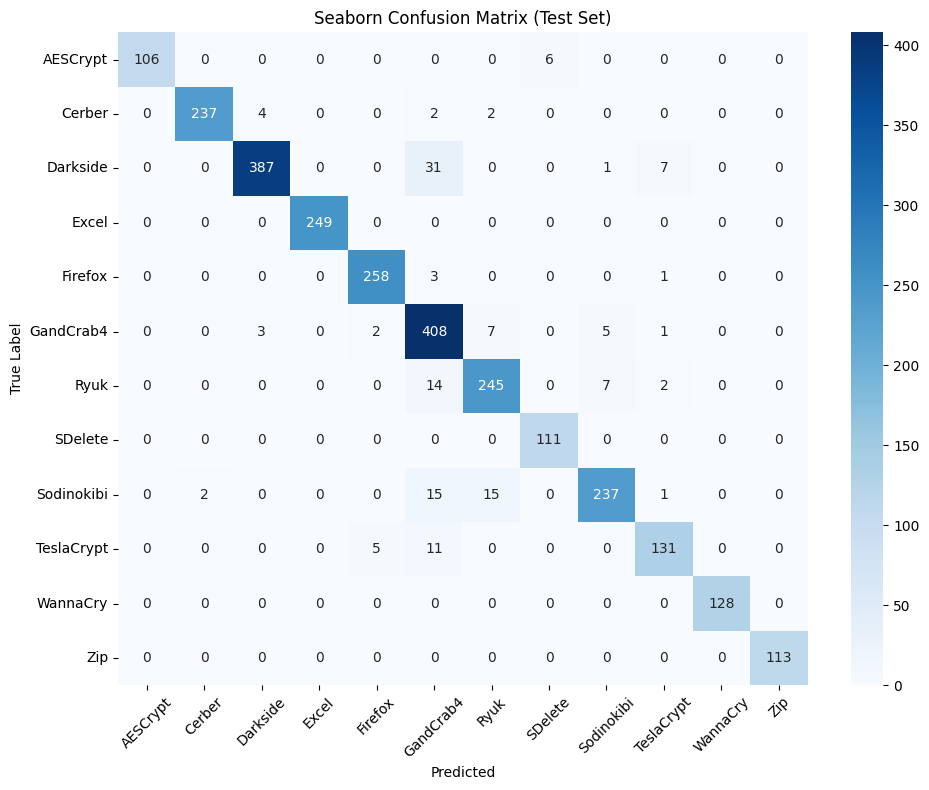

In [ ]:
# expected_shape = (CHUNK_SIZE, NUM_FEATURES)
# X_test, y_test = load_split_from_folder(os.path.join(INPUT_DIR, "test"), expected_shape)
# y_test_str = y_test

# test_dataset = MultiStreamDataset(X_test, y_test_str, label_encoder, augment=False)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# # Rebuild same model architecture
# model = MultiStreamCNN(input_length=CHUNK_SIZE, num_classes=len(label_encoder.classes_))
# model.load_state_dict(torch.load("teacher_full.pth"))
# model.to(device)
# model.eval()
# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for streams, labels in test_loader:
#         # Move to device
#         streams = [s.to(device) for s in streams]
#         labels = labels.to(device)

#         outputs = model(streams)
#         preds = outputs.argmax(dim=1)

#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

# # Inverse-transform for reporting
# pred_labels_str = label_encoder.inverse_transform(all_preds)
# true_labels_str = label_encoder.inverse_transform(all_labels)

# # === 5. Classification Report
# print("=== 🧪 Final Test Set Classification Report ===")
# print(classification_report(true_labels_str, pred_labels_str, digits=4))

# # === 6. Seaborn Confusion Matrix
# cm = confusion_matrix(true_labels_str, pred_labels_str, labels=label_encoder.classes_)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
# plt.xlabel("Predicted")
# plt.ylabel("True Label")
# plt.title("Seaborn Confusion Matrix (Test Set)")
# plt.xticks(rotation=45)
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()

In [30]:
import torch
import torch.nn as nn

class StudentCNN(nn.Module):
    def __init__(self, input_length, num_classes=12):
        super().__init__()
        self.streams = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(1, 4, kernel_size=3, padding=1),  # reduced filters
                nn.ReLU(),
                nn.Conv1d(4, 8, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.AdaptiveAvgPool1d(1),
                nn.Flatten()
            ) for _ in range(8)
        ])

        self.fc = nn.Sequential(
            nn.Linear(8 * 5, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

        # 🔄 Smaller projection for lightweight feature distillation
        self.proj = nn.Linear(8 * 5, 128)

    def forward(self, streams, return_features=False):
        features = [self.streams[i](streams[i]) for i in range(5)]
        x = torch.cat(features, dim=1)  # Shape: [B, 64]

        if return_features:
            feat_proj = self.proj(x)  # [B, 128]
            return self.fc(x), feat_proj

        return self.fc(x)


In [31]:
import torch.nn.functional as F

def distillation_loss(student_logits, teacher_logits, student_feat, teacher_feat, true_labels, T=3.0, alpha=0.5, beta=0.3, gamma=0.2):
    """
    alpha: weight for hard loss (CE)
    beta: weight for soft loss (KL)
    gamma: weight for feature-based distillation (MSE)
    T: temperature for soft distillation
    """
    # Hard loss
    ce_loss = F.cross_entropy(student_logits, true_labels)

    # Soft loss (logits)
    soft_teacher = F.softmax(teacher_logits / T, dim=1)
    soft_student = F.log_softmax(student_logits / T, dim=1)
    kl_loss = F.kl_div(soft_student, soft_teacher, reduction='batchmean') * (T * T)

    # Feature loss (projection-matched MSE)
    feat_loss = F.mse_loss(student_feat, teacher_feat)

    return alpha * ce_loss + beta * kl_loss + gamma * feat_loss


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_distilled(student, teacher, train_loader, val_loader, device,
                    epochs=50, lr=0.0005, class_weights=None,
                    T=3.0, alpha=0.5, beta=0.4, gamma=0.3,
                    best_model_path="best_student.pth"):
    """
    Train a student model using knowledge distillation from a teacher.

    Parameters:
        student: The student model to train
        teacher: The pre-trained teacher model (frozen)
        train_loader, val_loader: Dataloaders
        device: CUDA or CPU
        epochs: Training epochs
        lr: Learning rate
        class_weights: Tensor for class balancing
        T: Temperature for soft distillation
        alpha, beta, gamma: Distillation loss weights
        save_path: File to save the best student model

    Returns:
        Lists: train_accuracies, val_accuracies, train_losses, val_losses
    """

    teacher.eval()
    student.to(device)
    teacher.to(device)

    optimizer = optim.Adam(student.parameters(), lr=lr)
    criterion_ce = nn.CrossEntropyLoss(weight=class_weights)

    best_val_acc = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        student.train()
        running_loss, correct = 0.0, 0

        for streams, labels in train_loader:
            streams = [s.to(device) for s in streams]
            labels = labels.to(device)

            # Forward pass (with feature outputs)
            student_logits, student_feat = student(streams, return_features=True)
            with torch.no_grad():
                teacher_logits, teacher_feat = teacher(streams, return_features=True)

            # Compute KD loss
            loss = distillation_loss(
                student_logits, teacher_logits,
                student_feat, teacher_feat,
                labels,
                T=T, alpha=alpha, beta=beta, gamma=gamma
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += (student_logits.argmax(dim=1) == labels).sum().item()

        train_acc = correct / len(train_loader.dataset)
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # === Validation
        student.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for streams, labels in val_loader:
                streams = [s.to(device) for s in streams]
                labels = labels.to(device)
                outputs = student(streams)
                loss = criterion_ce(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(dim=1) == labels).sum().item()

        val_acc = val_correct / len(val_loader.dataset)
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)

        print(f"[Distill] Epoch {epoch+1:02d}/{epochs} - "
              f"Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} "
              f"- Val Loss: {val_losses[-1]:.4f} - Val Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(student.state_dict(), best_model_path)

    # Load best model before returning
    student.load_state_dict(torch.load(best_model_path))
    return train_accuracies, val_accuracies, train_losses, val_losses



🚀 Knowledge Distillation for Td=30, Tw=10


/tmp/ipykernel_1945517/3006587670.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load(teacher_path, map_location=device))


🔍 Finding optimal learning rate...


100%|██████████| 200/200 [00:03<00:00, 61.15it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 9.88E-03


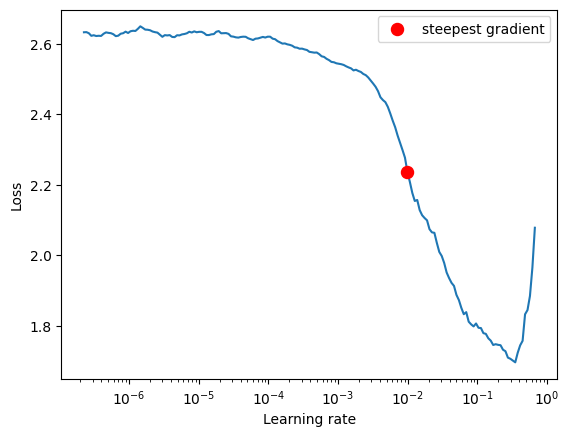

[Distill] Epoch 01/50 - Train Loss: 3.7942 - Train Acc: 0.5478 - Val Loss: 1.0093 - Val Acc: 0.6112
[Distill] Epoch 02/50 - Train Loss: 2.1899 - Train Acc: 0.7130 - Val Loss: 0.9275 - Val Acc: 0.6323
[Distill] Epoch 03/50 - Train Loss: 1.9077 - Train Acc: 0.7469 - Val Loss: 0.9378 - Val Acc: 0.6308
[Distill] Epoch 04/50 - Train Loss: 1.6684 - Train Acc: 0.7729 - Val Loss: 0.7558 - Val Acc: 0.7590
[Distill] Epoch 05/50 - Train Loss: 1.5940 - Train Acc: 0.7847 - Val Loss: 0.7555 - Val Acc: 0.7390
[Distill] Epoch 06/50 - Train Loss: 1.4770 - Train Acc: 0.7932 - Val Loss: 0.9026 - Val Acc: 0.6904
[Distill] Epoch 07/50 - Train Loss: 1.4411 - Train Acc: 0.8015 - Val Loss: 0.8382 - Val Acc: 0.7315
[Distill] Epoch 08/50 - Train Loss: 1.3563 - Train Acc: 0.8096 - Val Loss: 0.6251 - Val Acc: 0.7710
[Distill] Epoch 09/50 - Train Loss: 1.3191 - Train Acc: 0.8133 - Val Loss: 0.6482 - Val Acc: 0.7761
[Distill] Epoch 10/50 - Train Loss: 1.2956 - Train Acc: 0.8178 - Val Loss: 0.5762 - Val Acc: 0.7801


/tmp/ipykernel_1945517/578157597.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student.load_state_dict(torch.load(best_model_path))



📋 Classification Report (Td=30, Tw=10):
              precision    recall  f1-score   support

    AESCrypt       1.00      1.00      1.00        85
      Cerber       0.83      0.81      0.82       189
    Darkside       0.78      0.71      0.75       323
       Excel       1.00      1.00      1.00       147
     Firefox       1.00      0.99      0.99       204
   GandCrab4       0.64      0.82      0.72       319
        Ryuk       0.84      0.68      0.75       196
     SDelete       1.00      1.00      1.00        79
  Sodinokibi       0.90      0.73      0.81       205
  TeslaCrypt       0.73      0.92      0.81        85
    WannaCry       1.00      1.00      1.00        79
         Zip       1.00      1.00      1.00        85

    accuracy                           0.84      1996
   macro avg       0.89      0.89      0.89      1996
weighted avg       0.85      0.84      0.84      1996

✅ Final Training Accuracy: 0.8689
✅ Final Validation Accuracy: 0.8392

🚀 Knowledge Distillat

/tmp/ipykernel_1945517/3006587670.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load(teacher_path, map_location=device))


🔍 Finding optimal learning rate...


100%|██████████| 200/200 [00:03<00:00, 63.22it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 9.88E-03


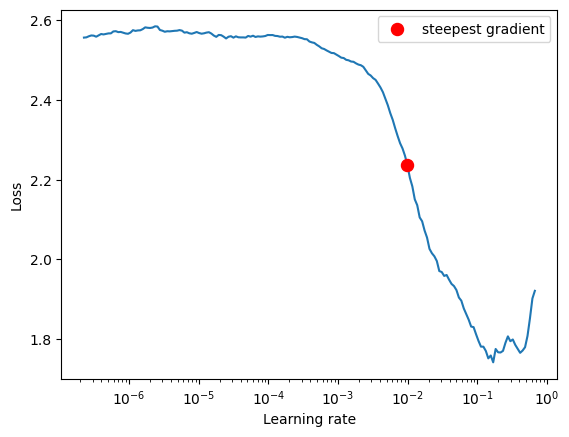

[Distill] Epoch 01/50 - Train Loss: 4.7217 - Train Acc: 0.5554 - Val Loss: 1.4493 - Val Acc: 0.5782
[Distill] Epoch 02/50 - Train Loss: 2.7592 - Train Acc: 0.7281 - Val Loss: 1.1505 - Val Acc: 0.6602
[Distill] Epoch 03/50 - Train Loss: 2.1876 - Train Acc: 0.7774 - Val Loss: 1.1309 - Val Acc: 0.6993
[Distill] Epoch 04/50 - Train Loss: 1.9349 - Train Acc: 0.7969 - Val Loss: 0.8635 - Val Acc: 0.7479
[Distill] Epoch 05/50 - Train Loss: 1.7835 - Train Acc: 0.8092 - Val Loss: 0.9129 - Val Acc: 0.7422
[Distill] Epoch 06/50 - Train Loss: 1.5966 - Train Acc: 0.8299 - Val Loss: 0.8858 - Val Acc: 0.7528
[Distill] Epoch 07/50 - Train Loss: 1.5162 - Train Acc: 0.8353 - Val Loss: 0.8154 - Val Acc: 0.7715
[Distill] Epoch 08/50 - Train Loss: 1.4735 - Train Acc: 0.8388 - Val Loss: 0.8059 - Val Acc: 0.7711
[Distill] Epoch 09/50 - Train Loss: 1.3883 - Train Acc: 0.8461 - Val Loss: 0.8222 - Val Acc: 0.7916
[Distill] Epoch 10/50 - Train Loss: 1.3832 - Train Acc: 0.8483 - Val Loss: 0.8240 - Val Acc: 0.7756


/tmp/ipykernel_1945517/578157597.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student.load_state_dict(torch.load(best_model_path))



📋 Classification Report (Td=30, Tw=15):
              precision    recall  f1-score   support

    AESCrypt       0.99      0.99      0.99       112
      Cerber       0.96      0.86      0.91       249
    Darkside       0.95      0.82      0.88       427
       Excel       0.98      0.94      0.96       194
     Firefox       0.91      0.94      0.93       271
   GandCrab4       0.69      0.77      0.73       420
        Ryuk       0.80      0.75      0.77       258
     SDelete       0.99      0.98      0.99       103
  Sodinokibi       0.83      0.85      0.84       271
  TeslaCrypt       0.59      0.82      0.68       114
    WannaCry       1.00      1.00      1.00       103
         Zip       1.00      0.96      0.98       112

    accuracy                           0.86      2634
   macro avg       0.89      0.89      0.89      2634
weighted avg       0.87      0.86      0.86      2634

✅ Final Training Accuracy: 0.9076
✅ Final Validation Accuracy: 0.8417

🚀 Knowledge Distillat

/tmp/ipykernel_1945517/3006587670.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load(teacher_path, map_location=device))


🔍 Finding optimal learning rate...


100%|██████████| 200/200 [00:03<00:00, 63.27it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.41E-03


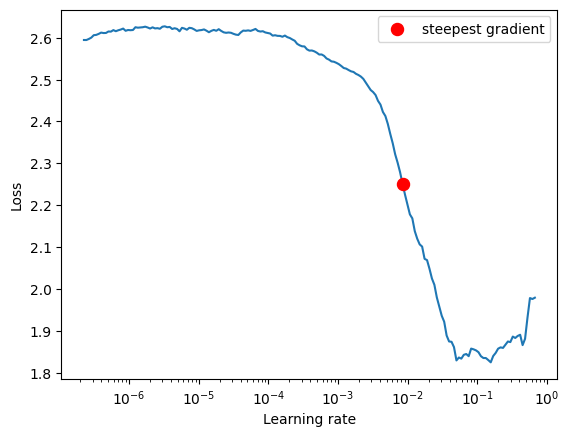

[Distill] Epoch 01/50 - Train Loss: 3.6654 - Train Acc: 0.6564 - Val Loss: 1.3578 - Val Acc: 0.6245
[Distill] Epoch 02/50 - Train Loss: 2.1093 - Train Acc: 0.7845 - Val Loss: 0.8845 - Val Acc: 0.7249
[Distill] Epoch 03/50 - Train Loss: 1.7603 - Train Acc: 0.8136 - Val Loss: 0.7855 - Val Acc: 0.7811
[Distill] Epoch 04/50 - Train Loss: 1.5665 - Train Acc: 0.8312 - Val Loss: 0.8723 - Val Acc: 0.7537
[Distill] Epoch 05/50 - Train Loss: 1.4654 - Train Acc: 0.8390 - Val Loss: 0.8923 - Val Acc: 0.7732
[Distill] Epoch 06/50 - Train Loss: 1.3644 - Train Acc: 0.8473 - Val Loss: 0.7560 - Val Acc: 0.8120
[Distill] Epoch 07/50 - Train Loss: 1.2813 - Train Acc: 0.8549 - Val Loss: 0.6876 - Val Acc: 0.8143
[Distill] Epoch 08/50 - Train Loss: 1.2312 - Train Acc: 0.8588 - Val Loss: 0.7063 - Val Acc: 0.8057
[Distill] Epoch 09/50 - Train Loss: 1.1844 - Train Acc: 0.8629 - Val Loss: 0.6533 - Val Acc: 0.8218
[Distill] Epoch 10/50 - Train Loss: 1.1654 - Train Acc: 0.8665 - Val Loss: 0.6932 - Val Acc: 0.8138


/tmp/ipykernel_1945517/578157597.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student.load_state_dict(torch.load(best_model_path))



📋 Classification Report (Td=30, Tw=20):
              precision    recall  f1-score   support

    AESCrypt       0.99      0.95      0.97       221
      Cerber       0.96      0.85      0.90       496
    Darkside       0.97      0.81      0.88       850
       Excel       0.95      0.97      0.96       386
     Firefox       0.94      0.94      0.94       539
   GandCrab4       0.74      0.74      0.74       836
        Ryuk       0.69      0.85      0.76       514
     SDelete       0.94      0.92      0.93       204
  Sodinokibi       0.93      0.78      0.85       537
  TeslaCrypt       0.53      0.89      0.66       224
    WannaCry       0.96      0.99      0.98       203
         Zip       0.99      1.00      0.99       220

    accuracy                           0.86      5230
   macro avg       0.88      0.89      0.88      5230
weighted avg       0.88      0.86      0.86      5230

✅ Final Training Accuracy: 0.9047
✅ Final Validation Accuracy: 0.8535

🚀 Knowledge Distillat

/tmp/ipykernel_1945517/3006587670.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load(teacher_path, map_location=device))


🔍 Finding optimal learning rate...


100%|██████████| 200/200 [00:03<00:00, 55.94it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.37E-02


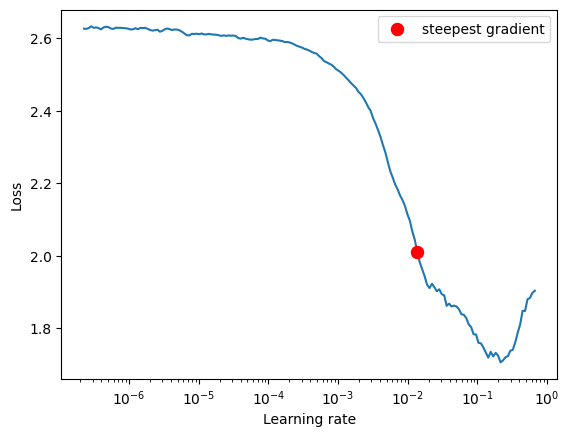

[Distill] Epoch 01/50 - Train Loss: 5.0206 - Train Acc: 0.5104 - Val Loss: 1.4960 - Val Acc: 0.5514
[Distill] Epoch 02/50 - Train Loss: 2.3720 - Train Acc: 0.7634 - Val Loss: 0.9568 - Val Acc: 0.7103
[Distill] Epoch 03/50 - Train Loss: 1.7444 - Train Acc: 0.8200 - Val Loss: 0.8479 - Val Acc: 0.7442
[Distill] Epoch 04/50 - Train Loss: 1.4317 - Train Acc: 0.8511 - Val Loss: 0.6490 - Val Acc: 0.8110
[Distill] Epoch 05/50 - Train Loss: 1.2627 - Train Acc: 0.8692 - Val Loss: 0.5418 - Val Acc: 0.8391
[Distill] Epoch 06/50 - Train Loss: 1.1213 - Train Acc: 0.8803 - Val Loss: 0.7042 - Val Acc: 0.7926
[Distill] Epoch 07/50 - Train Loss: 1.1252 - Train Acc: 0.8838 - Val Loss: 0.5778 - Val Acc: 0.8314
[Distill] Epoch 08/50 - Train Loss: 1.0558 - Train Acc: 0.8832 - Val Loss: 0.5020 - Val Acc: 0.8479
[Distill] Epoch 09/50 - Train Loss: 0.9709 - Train Acc: 0.8947 - Val Loss: 0.4957 - Val Acc: 0.8411
[Distill] Epoch 10/50 - Train Loss: 0.9565 - Train Acc: 0.8977 - Val Loss: 0.5732 - Val Acc: 0.8304


/tmp/ipykernel_1945517/578157597.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student.load_state_dict(torch.load(best_model_path))



📋 Classification Report (Td=45, Tw=10):
              precision    recall  f1-score   support

    AESCrypt       1.00      0.95      0.97        39
      Cerber       0.94      0.87      0.90       100
    Darkside       0.96      0.86      0.91       178
       Excel       1.00      1.00      1.00        74
     Firefox       0.97      0.94      0.95       108
   GandCrab4       0.77      0.91      0.84       175
        Ryuk       0.95      0.73      0.82       103
     SDelete       1.00      1.00      1.00        36
  Sodinokibi       0.85      0.95      0.90       109
  TeslaCrypt       0.77      0.90      0.83        40
    WannaCry       1.00      1.00      1.00        33
         Zip       0.95      1.00      0.97        37

    accuracy                           0.90      1032
   macro avg       0.93      0.93      0.92      1032
weighted avg       0.91      0.90      0.90      1032

✅ Final Training Accuracy: 0.9421
✅ Final Validation Accuracy: 0.8915

🚀 Knowledge Distillat

/tmp/ipykernel_1945517/3006587670.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load(teacher_path, map_location=device))


🔍 Finding optimal learning rate...


100%|██████████| 200/200 [00:03<00:00, 62.90it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.83E-02


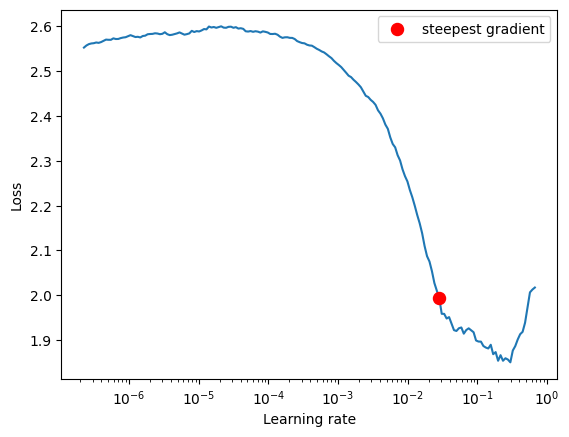

[Distill] Epoch 01/50 - Train Loss: 4.5405 - Train Acc: 0.5837 - Val Loss: 1.1819 - Val Acc: 0.6742
[Distill] Epoch 02/50 - Train Loss: 2.3264 - Train Acc: 0.7826 - Val Loss: 0.9363 - Val Acc: 0.7275
[Distill] Epoch 03/50 - Train Loss: 1.8678 - Train Acc: 0.8265 - Val Loss: 0.8898 - Val Acc: 0.7524
[Distill] Epoch 04/50 - Train Loss: 1.5859 - Train Acc: 0.8467 - Val Loss: 0.7855 - Val Acc: 0.7809
[Distill] Epoch 05/50 - Train Loss: 1.4286 - Train Acc: 0.8638 - Val Loss: 0.6331 - Val Acc: 0.7684
[Distill] Epoch 06/50 - Train Loss: 1.2501 - Train Acc: 0.8791 - Val Loss: 0.5712 - Val Acc: 0.8335
[Distill] Epoch 07/50 - Train Loss: 1.2005 - Train Acc: 0.8827 - Val Loss: 0.4656 - Val Acc: 0.8451
[Distill] Epoch 08/50 - Train Loss: 1.0475 - Train Acc: 0.8944 - Val Loss: 0.5527 - Val Acc: 0.8327
[Distill] Epoch 09/50 - Train Loss: 1.0430 - Train Acc: 0.8966 - Val Loss: 0.4921 - Val Acc: 0.8568
[Distill] Epoch 10/50 - Train Loss: 0.9606 - Train Acc: 0.9051 - Val Loss: 0.4502 - Val Acc: 0.8649


/tmp/ipykernel_1945517/578157597.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student.load_state_dict(torch.load(best_model_path))



📋 Classification Report (Td=45, Tw=15):
              precision    recall  f1-score   support

    AESCrypt       1.00      1.00      1.00        53
      Cerber       0.97      0.95      0.96       132
    Darkside       0.98      0.86      0.91       232
       Excel       1.00      0.96      0.98       100
     Firefox       0.94      0.95      0.94       143
   GandCrab4       0.79      0.90      0.84       228
        Ryuk       0.91      0.84      0.87       137
     SDelete       0.98      1.00      0.99        48
  Sodinokibi       0.96      0.90      0.93       143
  TeslaCrypt       0.72      0.98      0.83        53
    WannaCry       1.00      1.00      1.00        48
         Zip       1.00      1.00      1.00        52

    accuracy                           0.92      1369
   macro avg       0.94      0.95      0.94      1369
weighted avg       0.93      0.92      0.92      1369

✅ Final Training Accuracy: 0.9504
✅ Final Validation Accuracy: 0.9102

🚀 Knowledge Distillat

/tmp/ipykernel_1945517/3006587670.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load(teacher_path, map_location=device))


🔍 Finding optimal learning rate...


100%|██████████| 200/200 [00:03<00:00, 62.65it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.05E-02


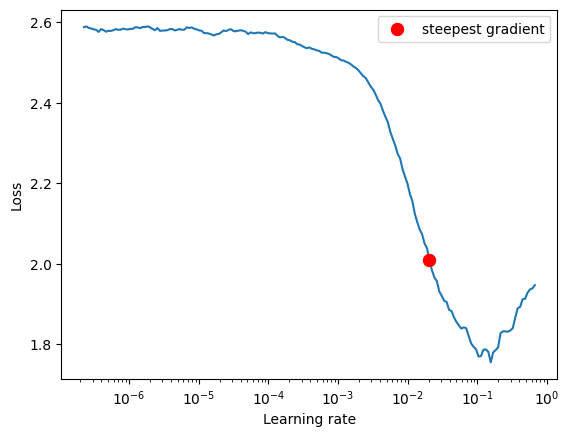

[Distill] Epoch 01/50 - Train Loss: 4.9053 - Train Acc: 0.5356 - Val Loss: 1.6366 - Val Acc: 0.5899
[Distill] Epoch 02/50 - Train Loss: 2.6236 - Train Acc: 0.7525 - Val Loss: 1.0640 - Val Acc: 0.6972
[Distill] Epoch 03/50 - Train Loss: 2.0104 - Train Acc: 0.8060 - Val Loss: 0.8302 - Val Acc: 0.7363
[Distill] Epoch 04/50 - Train Loss: 1.6951 - Train Acc: 0.8345 - Val Loss: 0.8680 - Val Acc: 0.7375
[Distill] Epoch 05/50 - Train Loss: 1.5469 - Train Acc: 0.8479 - Val Loss: 0.6822 - Val Acc: 0.8032
[Distill] Epoch 06/50 - Train Loss: 1.3525 - Train Acc: 0.8636 - Val Loss: 0.6428 - Val Acc: 0.8151
[Distill] Epoch 07/50 - Train Loss: 1.2586 - Train Acc: 0.8749 - Val Loss: 0.5602 - Val Acc: 0.8372
[Distill] Epoch 08/50 - Train Loss: 1.1733 - Train Acc: 0.8789 - Val Loss: 0.7087 - Val Acc: 0.8145
[Distill] Epoch 09/50 - Train Loss: 1.1202 - Train Acc: 0.8869 - Val Loss: 0.7711 - Val Acc: 0.8069
[Distill] Epoch 10/50 - Train Loss: 1.0489 - Train Acc: 0.8938 - Val Loss: 0.5037 - Val Acc: 0.8479


/tmp/ipykernel_1945517/578157597.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student.load_state_dict(torch.load(best_model_path))



📋 Classification Report (Td=45, Tw=20):
              precision    recall  f1-score   support

    AESCrypt       1.00      0.97      0.98        60
      Cerber       0.95      0.91      0.93       152
    Darkside       0.99      0.84      0.91       270
       Excel       0.94      1.00      0.97       115
     Firefox       0.92      0.96      0.94       166
   GandCrab4       0.78      0.88      0.82       265
        Ryuk       0.84      0.85      0.85       158
     SDelete       0.96      1.00      0.98        55
  Sodinokibi       0.93      0.93      0.93       167
  TeslaCrypt       0.87      0.87      0.87        62
    WannaCry       1.00      1.00      1.00        55
         Zip       1.00      1.00      1.00        60

    accuracy                           0.91      1585
   macro avg       0.93      0.93      0.93      1585
weighted avg       0.92      0.91      0.91      1585

✅ Final Training Accuracy: 0.9421
✅ Final Validation Accuracy: 0.8921

🚀 Knowledge Distillat

/tmp/ipykernel_1945517/3006587670.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load(teacher_path, map_location=device))


🔍 Finding optimal learning rate...


100%|██████████| 200/200 [00:03<00:00, 61.47it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.26E-02


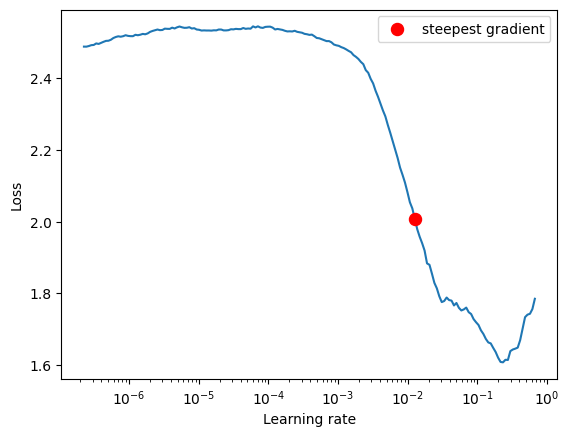

[Distill] Epoch 01/50 - Train Loss: 5.4738 - Train Acc: 0.4986 - Val Loss: 1.3258 - Val Acc: 0.5604
[Distill] Epoch 02/50 - Train Loss: 2.7446 - Train Acc: 0.7398 - Val Loss: 1.1216 - Val Acc: 0.6812
[Distill] Epoch 03/50 - Train Loss: 2.0277 - Train Acc: 0.8146 - Val Loss: 1.0033 - Val Acc: 0.7525
[Distill] Epoch 04/50 - Train Loss: 1.7105 - Train Acc: 0.8400 - Val Loss: 0.7520 - Val Acc: 0.7904
[Distill] Epoch 05/50 - Train Loss: 1.4950 - Train Acc: 0.8646 - Val Loss: 0.9388 - Val Acc: 0.7598
[Distill] Epoch 06/50 - Train Loss: 1.3833 - Train Acc: 0.8708 - Val Loss: 0.7243 - Val Acc: 0.8064
[Distill] Epoch 07/50 - Train Loss: 1.2645 - Train Acc: 0.8870 - Val Loss: 0.5828 - Val Acc: 0.8472
[Distill] Epoch 08/50 - Train Loss: 1.1576 - Train Acc: 0.8930 - Val Loss: 0.5887 - Val Acc: 0.8486
[Distill] Epoch 09/50 - Train Loss: 1.1287 - Train Acc: 0.8940 - Val Loss: 0.4836 - Val Acc: 0.8748
[Distill] Epoch 10/50 - Train Loss: 1.0049 - Train Acc: 0.9047 - Val Loss: 0.5286 - Val Acc: 0.8457


/tmp/ipykernel_1945517/578157597.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student.load_state_dict(torch.load(best_model_path))



📋 Classification Report (Td=60, Tw=10):
              precision    recall  f1-score   support

    AESCrypt       1.00      0.95      0.98        21
      Cerber       0.91      0.90      0.90        68
    Darkside       0.98      0.84      0.91       126
       Excel       1.00      1.00      1.00        49
     Firefox       1.00      0.89      0.94        74
   GandCrab4       0.86      0.89      0.87       125
        Ryuk       0.86      0.93      0.89        71
     SDelete       1.00      1.00      1.00        18
  Sodinokibi       0.86      0.96      0.90        74
  TeslaCrypt       0.73      1.00      0.85        22
    WannaCry       0.94      0.94      0.94        18
         Zip       0.95      1.00      0.98        21

    accuracy                           0.91       687
   macro avg       0.92      0.94      0.93       687
weighted avg       0.92      0.91      0.91       687

✅ Final Training Accuracy: 0.9641
✅ Final Validation Accuracy: 0.9054

🚀 Knowledge Distillat

/tmp/ipykernel_1945517/3006587670.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load(teacher_path, map_location=device))


🔍 Finding optimal learning rate...


100%|██████████| 200/200 [00:03<00:00, 63.92it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.15E-03


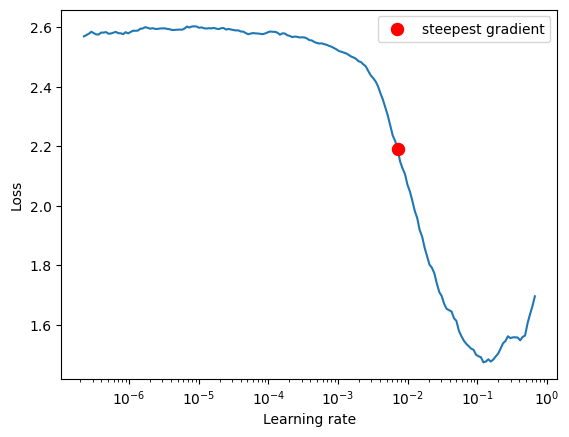

[Distill] Epoch 01/50 - Train Loss: 5.1185 - Train Acc: 0.5460 - Val Loss: 1.1692 - Val Acc: 0.6089
[Distill] Epoch 02/50 - Train Loss: 2.3098 - Train Acc: 0.7954 - Val Loss: 0.8633 - Val Acc: 0.7241
[Distill] Epoch 03/50 - Train Loss: 1.6385 - Train Acc: 0.8529 - Val Loss: 0.7555 - Val Acc: 0.7595
[Distill] Epoch 04/50 - Train Loss: 1.4599 - Train Acc: 0.8634 - Val Loss: 0.5916 - Val Acc: 0.7886
[Distill] Epoch 05/50 - Train Loss: 1.2807 - Train Acc: 0.8781 - Val Loss: 0.5998 - Val Acc: 0.8013
[Distill] Epoch 06/50 - Train Loss: 1.2133 - Train Acc: 0.8856 - Val Loss: 0.7268 - Val Acc: 0.7835
[Distill] Epoch 07/50 - Train Loss: 1.1139 - Train Acc: 0.8972 - Val Loss: 0.5458 - Val Acc: 0.8127
[Distill] Epoch 08/50 - Train Loss: 1.0176 - Train Acc: 0.9068 - Val Loss: 0.5653 - Val Acc: 0.8291
[Distill] Epoch 09/50 - Train Loss: 1.0109 - Train Acc: 0.9071 - Val Loss: 0.6197 - Val Acc: 0.8253
[Distill] Epoch 10/50 - Train Loss: 0.9077 - Train Acc: 0.9164 - Val Loss: 0.4398 - Val Acc: 0.8620


/tmp/ipykernel_1945517/578157597.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student.load_state_dict(torch.load(best_model_path))



📋 Classification Report (Td=60, Tw=15):
              precision    recall  f1-score   support

    AESCrypt       1.00      1.00      1.00        27
      Cerber       0.99      0.96      0.97        76
    Darkside       0.98      0.89      0.93       142
       Excel       1.00      0.98      0.99        56
     Firefox       0.97      0.98      0.97        85
   GandCrab4       0.85      0.88      0.87       138
        Ryuk       0.89      0.90      0.89        79
     SDelete       0.96      1.00      0.98        24
  Sodinokibi       0.92      0.96      0.94        84
  TeslaCrypt       0.79      0.96      0.87        28
    WannaCry       1.00      0.96      0.98        24
         Zip       1.00      1.00      1.00        27

    accuracy                           0.94       790
   macro avg       0.95      0.96      0.95       790
weighted avg       0.94      0.94      0.94       790

✅ Final Training Accuracy: 0.9632
✅ Final Validation Accuracy: 0.9354

🚀 Knowledge Distillat

/tmp/ipykernel_1945517/3006587670.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load(teacher_path, map_location=device))


🔍 Finding optimal learning rate...


100%|██████████| 200/200 [00:03<00:00, 61.30it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.05E-02


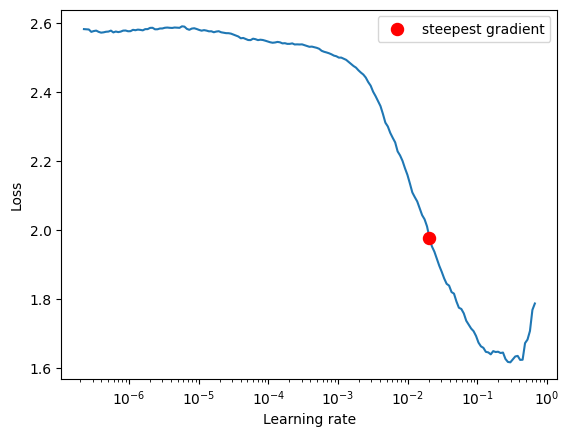

[Distill] Epoch 01/50 - Train Loss: 5.8863 - Train Acc: 0.4513 - Val Loss: 1.7510 - Val Acc: 0.5234
[Distill] Epoch 02/50 - Train Loss: 3.4945 - Train Acc: 0.6727 - Val Loss: 1.1657 - Val Acc: 0.6511
[Distill] Epoch 03/50 - Train Loss: 2.6367 - Train Acc: 0.7527 - Val Loss: 0.9247 - Val Acc: 0.7400
[Distill] Epoch 04/50 - Train Loss: 2.2019 - Train Acc: 0.7922 - Val Loss: 0.7470 - Val Acc: 0.7424
[Distill] Epoch 05/50 - Train Loss: 1.9712 - Train Acc: 0.8097 - Val Loss: 0.9590 - Val Acc: 0.7588
[Distill] Epoch 06/50 - Train Loss: 1.7737 - Train Acc: 0.8350 - Val Loss: 0.7134 - Val Acc: 0.7740
[Distill] Epoch 07/50 - Train Loss: 1.6586 - Train Acc: 0.8436 - Val Loss: 0.5843 - Val Acc: 0.8080
[Distill] Epoch 08/50 - Train Loss: 1.5257 - Train Acc: 0.8519 - Val Loss: 0.6874 - Val Acc: 0.7658
[Distill] Epoch 09/50 - Train Loss: 1.4751 - Train Acc: 0.8576 - Val Loss: 0.7297 - Val Acc: 0.7822
[Distill] Epoch 10/50 - Train Loss: 1.4097 - Train Acc: 0.8645 - Val Loss: 0.4988 - Val Acc: 0.8267


/tmp/ipykernel_1945517/578157597.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student.load_state_dict(torch.load(best_model_path))



📋 Classification Report (Td=60, Tw=20):
              precision    recall  f1-score   support

    AESCrypt       1.00      0.86      0.92        28
      Cerber       0.91      0.89      0.90        84
    Darkside       0.94      0.85      0.89       154
       Excel       0.98      0.98      0.98        61
     Firefox       0.99      0.98      0.98        91
   GandCrab4       0.78      0.93      0.85       151
        Ryuk       0.93      0.75      0.83        88
     SDelete       1.00      1.00      1.00        24
  Sodinokibi       0.91      0.88      0.89        91
  TeslaCrypt       0.68      0.89      0.77        28
    WannaCry       1.00      1.00      1.00        25
         Zip       0.88      1.00      0.94        29

    accuracy                           0.90       854
   macro avg       0.92      0.92      0.91       854
weighted avg       0.91      0.90      0.90       854

✅ Final Training Accuracy: 0.9298
✅ Final Validation Accuracy: 0.8946


In [33]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torch_lr_finder import LRFinder

# === Config
base_dir = "/home/HardDisk/Satang/thesis_proj"
teacher_dir = "/home/HardDisk/Satang/thesis_proj/Deep_Learning/multi_cnn_5/teacher"
save_root = "/home/HardDisk/Satang/thesis_proj/Deep_Learning/multi_cnn_5/student"
os.makedirs(save_root, exist_ok=True)

detection_times = [30, 45, 60]
window_sizes = [10, 15, 20]
NUM_EPOCHS = 50
BATCH_SIZE = 64
NUM_FEATURES = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for T_d in detection_times:
    for T_w in window_sizes:
        print(f"\n🚀 Knowledge Distillation for Td={T_d}, Tw={T_w}")
        T_len = T_d - T_w + 1
        expected_shape = (T_len, NUM_FEATURES)
        folder = f"X_csv_split_{T_len}"
        input_dir = os.path.join(base_dir, f"New_{T_d}", f"{T_w}", "split_tws_5", folder)
        train_path = os.path.join(input_dir, "train")
        val_path = os.path.join(input_dir, "val")

        # === Load Data
        X_train, y_train = load_split_from_folder(train_path, expected_shape)
        X_val, y_val = load_split_from_folder(val_path, expected_shape)

        # === SMOTE
        label_encoder = LabelEncoder()
        y_train_enc = label_encoder.fit_transform(y_train)
        X_train_flat = X_train.reshape(X_train.shape[0], -1)
        X_bal, y_bal = SMOTE().fit_resample(X_train_flat, y_train_enc)
        X_train_res = X_bal.reshape(-1, T_len, NUM_FEATURES)
        y_train_res = label_encoder.inverse_transform(y_bal)

        # === Dataset
        train_dataset = MultiStreamDataset(X_train_res, y_train_res, label_encoder, augment=True)
        val_dataset = MultiStreamDataset(X_val, y_val, label_encoder, augment=False)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

        # === Load Teacher
        teacher_path = os.path.join(teacher_dir, f"teacher_Td{T_d}_Tw{T_w}.pth")
        teacher = MultiStreamCNN(input_length=T_len, num_classes=len(label_encoder.classes_))
        teacher.load_state_dict(torch.load(teacher_path, map_location=device))
        teacher.to(device)
        teacher.eval()

        # === Class Weights
        class_weights = compute_class_weights(label_encoder.transform(y_train_res), device)

        # === LR Finder
        model_for_lr = StudentCNN(input_length=T_len, num_classes=len(label_encoder.classes_)).to(device)
        optimizer = torch.optim.Adam(model_for_lr.parameters(), lr=1e-7)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        print("🔍 Finding optimal learning rate...")
        lr_finder = LRFinder(model_for_lr, optimizer, criterion, device=device)
        lr_finder.range_test(train_loader, end_lr=1, num_iter=200)
        lr_finder.plot()
        lr_finder.reset()
        BEST_LR = 0.01  # Manually update this after inspecting plots

        # === Train Student KD
        student = StudentCNN(input_length=T_len, num_classes=len(label_encoder.classes_)).to(device)
        train_accs, val_accs, train_losses, val_losses = train_distilled(
            student=student,
            teacher=teacher,
            train_loader=train_loader,
            val_loader=val_loader,
            device=device,
            epochs=NUM_EPOCHS,
            lr=BEST_LR,
            class_weights=class_weights,
            T=3.0,
            alpha=0.5,
            best_model_path=os.path.join(save_root, f"student_KD_Td{T_d}_Tw{T_w}.pth")
        )

        # === Evaluate
        student.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for streams, labels in val_loader:
                streams = [s.to(device) for s in streams]
                labels = labels.to(device)
                outputs = student(streams)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # === Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=label_encoder.classes_,
                    yticklabels=label_encoder.classes_)
        plt.title(f"KD Confusion Matrix (Td={T_d}, Tw={T_w})")
        plt.tight_layout()
        plt.savefig(os.path.join(save_root, f"confmat_Td{T_d}_Tw{T_w}.png"))
        plt.close()

        # === Report
        print(f"\n📋 Classification Report (Td={T_d}, Tw={T_w}):")
        print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))
        print(f"✅ Final Training Accuracy: {train_accs[-1]:.4f}")
        print(f"✅ Final Validation Accuracy: {val_accs[-1]:.4f}")


In [34]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_student_baseline(student, train_loader, val_loader, device,
                           epochs=50, lr=0.0005, class_weights=None,
                           best_model_path="best_student_baseline.pth"):
    """
    Train a standalone student model (no knowledge distillation).

    Parameters:
        student: The student model to train
        train_loader, val_loader: PyTorch DataLoaders
        device: torch.device (CPU or CUDA)
        epochs: Number of training epochs
        lr: Learning rate
        class_weights: Optional tensor for class balancing
        best_model_path: Path to save the best model checkpoint

    Returns:
        train_accuracies, val_accuracies, train_losses, val_losses
    """
    student.to(device)
    optimizer = optim.Adam(student.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    best_val_acc = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        student.train()
        total_loss, correct = 0.0, 0

        for streams, labels in train_loader:
            streams = [s.to(device) for s in streams]
            labels = labels.to(device)

            outputs = student(streams)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()

        train_acc = correct / len(train_loader.dataset)
        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(train_acc)

        # === Validation ===
        student.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for streams, labels in val_loader:
                streams = [s.to(device) for s in streams]
                labels = labels.to(device)

                outputs = student(streams)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(dim=1) == labels).sum().item()

        val_acc = val_correct / len(val_loader.dataset)
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)

        print(f"[Baseline] Epoch {epoch+1:02d}/{epochs} - "
              f"Train Loss: {train_losses[-1]:.4f} - Train Acc: {train_acc:.4f} "
              f"- Val Loss: {val_losses[-1]:.4f} - Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(student.state_dict(), best_model_path)

    student.load_state_dict(torch.load(best_model_path))
    return train_accuracies, val_accuracies, train_losses, val_losses


In [38]:
import os
import torch
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from torch.utils.data import DataLoader

# === Assumed to already be defined in your environment ===
# - base_dir
# - detection_times = [30, 45, 60]
# - window_sizes = [10, 15, 20]
# - NUM_FEATURES = 8
# - BATCH_SIZE
# - NUM_EPOCHS
# - device (torch.device)
# - load_split_from_folder()
# - compute_class_weights()
# - MultiStreamDataset
# - StudentCNN
# - train_student_baseline()

baseline_save_dir = "/home/HardDisk/Satang/thesis_proj/Deep_Learning/multi_cnn_5/baseline_student"
os.makedirs(baseline_save_dir, exist_ok=True)

for T_d in detection_times:
    for T_w in window_sizes:
        T_len = T_d - T_w + 1
        expected_shape = (T_len, NUM_FEATURES)

        print(f"\n🚀 Training Standalone Student for Td={T_d}, Tw={T_w} (T_len={T_len})")

        # === Paths
        folder_name = f"X_csv_split_{T_len}"
        input_dir = os.path.join(base_dir, f"New_{T_d}", f"{T_w}", "split_tws_5", folder_name)
        train_path = os.path.join(input_dir, "train")
        val_path   = os.path.join(input_dir, "val")
        model_path = os.path.join(baseline_save_dir, f"student_baseline_Td{T_d}_Tw{T_w}.pth")

        # === Load Data
        X_train_raw, y_train_raw = load_split_from_folder(train_path, expected_shape)
        X_val_raw, y_val_raw     = load_split_from_folder(val_path, expected_shape)

        # === Encode + Apply SMOTE
        label_encoder = LabelEncoder()
        y_train_enc = label_encoder.fit_transform(y_train_raw)
        X_train_flat = X_train_raw.reshape(X_train_raw.shape[0], -1)
        X_resampled, y_resampled = SMOTE().fit_resample(X_train_flat, y_train_enc)
        X_train_bal = X_resampled.reshape(-1, T_len, NUM_FEATURES)
        y_train_str = label_encoder.inverse_transform(y_resampled)

        # === Create Datasets and Loaders
        train_dataset = MultiStreamDataset(X_train_bal, y_train_str, label_encoder, augment=True)
        val_dataset   = MultiStreamDataset(X_val_raw, y_val_raw, label_encoder, augment=False)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

        # === Compute class weights from rebalanced data
        class_weights_tensor = compute_class_weights(label_encoder.transform(y_train_str), device)

        # === Initialize and Train Model
        student_model = StudentCNN(input_length=T_len, num_classes=len(label_encoder.classes_)).to(device)
        train_accs, val_accs, train_losses, val_losses = train_student_baseline(
            student=student_model,
            train_loader=train_loader,
            val_loader=val_loader,
            device=device,
            epochs=NUM_EPOCHS,
            lr=0.01,
            class_weights=class_weights_tensor,
            best_model_path=model_path
        )

        print(f"✅ Saved baseline model to: {model_path}")



🚀 Training Standalone Student for Td=30, Tw=10 (T_len=21)
[Baseline] Epoch 01/50 - Train Loss: 1.2197 - Train Acc: 0.5116 - Val Loss: 1.1813 - Val Acc: 0.4629
[Baseline] Epoch 02/50 - Train Loss: 0.8751 - Train Acc: 0.6521 - Val Loss: 1.0556 - Val Acc: 0.5872
[Baseline] Epoch 03/50 - Train Loss: 0.7614 - Train Acc: 0.7050 - Val Loss: 0.8656 - Val Acc: 0.6132
[Baseline] Epoch 04/50 - Train Loss: 0.6901 - Train Acc: 0.7351 - Val Loss: 0.8314 - Val Acc: 0.6884
[Baseline] Epoch 05/50 - Train Loss: 0.6557 - Train Acc: 0.7486 - Val Loss: 0.7713 - Val Acc: 0.7114
[Baseline] Epoch 06/50 - Train Loss: 0.6312 - Train Acc: 0.7618 - Val Loss: 0.7597 - Val Acc: 0.7119
[Baseline] Epoch 07/50 - Train Loss: 0.6120 - Train Acc: 0.7673 - Val Loss: 0.7704 - Val Acc: 0.7109
[Baseline] Epoch 08/50 - Train Loss: 0.5991 - Train Acc: 0.7746 - Val Loss: 0.6928 - Val Acc: 0.7270
[Baseline] Epoch 09/50 - Train Loss: 0.5800 - Train Acc: 0.7808 - Val Loss: 0.6819 - Val Acc: 0.7385
[Baseline] Epoch 10/50 - Train L

/tmp/ipykernel_1945517/1956974357.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student.load_state_dict(torch.load(best_model_path))


[Baseline] Epoch 01/50 - Train Loss: 1.0392 - Train Acc: 0.6240 - Val Loss: 0.9902 - Val Acc: 0.6257
[Baseline] Epoch 02/50 - Train Loss: 0.6681 - Train Acc: 0.7605 - Val Loss: 0.7664 - Val Acc: 0.7134
[Baseline] Epoch 03/50 - Train Loss: 0.5792 - Train Acc: 0.7906 - Val Loss: 0.7277 - Val Acc: 0.7115
[Baseline] Epoch 04/50 - Train Loss: 0.5199 - Train Acc: 0.8112 - Val Loss: 0.6949 - Val Acc: 0.7361
[Baseline] Epoch 05/50 - Train Loss: 0.4961 - Train Acc: 0.8206 - Val Loss: 0.6696 - Val Acc: 0.7491
[Baseline] Epoch 06/50 - Train Loss: 0.4588 - Train Acc: 0.8349 - Val Loss: 0.5990 - Val Acc: 0.7654
[Baseline] Epoch 07/50 - Train Loss: 0.4493 - Train Acc: 0.8381 - Val Loss: 0.5429 - Val Acc: 0.7969
[Baseline] Epoch 08/50 - Train Loss: 0.4234 - Train Acc: 0.8414 - Val Loss: 0.6332 - Val Acc: 0.7718
[Baseline] Epoch 09/50 - Train Loss: 0.4091 - Train Acc: 0.8521 - Val Loss: 0.5530 - Val Acc: 0.7912
[Baseline] Epoch 10/50 - Train Loss: 0.4046 - Train Acc: 0.8547 - Val Loss: 0.5636 - Val Ac

/tmp/ipykernel_1945517/1956974357.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student.load_state_dict(torch.load(best_model_path))


[Baseline] Epoch 01/50 - Train Loss: 0.9264 - Train Acc: 0.6647 - Val Loss: 0.8164 - Val Acc: 0.6929
[Baseline] Epoch 02/50 - Train Loss: 0.6029 - Train Acc: 0.7805 - Val Loss: 0.6947 - Val Acc: 0.7367
[Baseline] Epoch 03/50 - Train Loss: 0.5293 - Train Acc: 0.8068 - Val Loss: 0.7082 - Val Acc: 0.7363
[Baseline] Epoch 04/50 - Train Loss: 0.4918 - Train Acc: 0.8211 - Val Loss: 0.6721 - Val Acc: 0.7350
[Baseline] Epoch 05/50 - Train Loss: 0.4607 - Train Acc: 0.8332 - Val Loss: 0.6740 - Val Acc: 0.7430
[Baseline] Epoch 06/50 - Train Loss: 0.4417 - Train Acc: 0.8392 - Val Loss: 0.6159 - Val Acc: 0.7642
[Baseline] Epoch 07/50 - Train Loss: 0.4249 - Train Acc: 0.8459 - Val Loss: 0.6095 - Val Acc: 0.7654
[Baseline] Epoch 08/50 - Train Loss: 0.4041 - Train Acc: 0.8525 - Val Loss: 0.5698 - Val Acc: 0.7776
[Baseline] Epoch 09/50 - Train Loss: 0.3997 - Train Acc: 0.8549 - Val Loss: 0.5408 - Val Acc: 0.8168
[Baseline] Epoch 10/50 - Train Loss: 0.3880 - Train Acc: 0.8589 - Val Loss: 0.5664 - Val Ac

/tmp/ipykernel_1945517/1956974357.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student.load_state_dict(torch.load(best_model_path))


[Baseline] Epoch 01/50 - Train Loss: 1.1450 - Train Acc: 0.5907 - Val Loss: 0.9727 - Val Acc: 0.6357
[Baseline] Epoch 02/50 - Train Loss: 0.5963 - Train Acc: 0.7889 - Val Loss: 0.8079 - Val Acc: 0.7006
[Baseline] Epoch 03/50 - Train Loss: 0.4963 - Train Acc: 0.8201 - Val Loss: 0.7832 - Val Acc: 0.7306
[Baseline] Epoch 04/50 - Train Loss: 0.4501 - Train Acc: 0.8382 - Val Loss: 0.6298 - Val Acc: 0.7645
[Baseline] Epoch 05/50 - Train Loss: 0.4055 - Train Acc: 0.8514 - Val Loss: 0.5774 - Val Acc: 0.7878
[Baseline] Epoch 06/50 - Train Loss: 0.3849 - Train Acc: 0.8598 - Val Loss: 0.5168 - Val Acc: 0.8198
[Baseline] Epoch 07/50 - Train Loss: 0.3531 - Train Acc: 0.8713 - Val Loss: 0.5169 - Val Acc: 0.8285
[Baseline] Epoch 08/50 - Train Loss: 0.3278 - Train Acc: 0.8806 - Val Loss: 0.4897 - Val Acc: 0.8314
[Baseline] Epoch 09/50 - Train Loss: 0.3137 - Train Acc: 0.8884 - Val Loss: 0.5138 - Val Acc: 0.8140
[Baseline] Epoch 10/50 - Train Loss: 0.2987 - Train Acc: 0.8941 - Val Loss: 0.5296 - Val Ac

/tmp/ipykernel_1945517/1956974357.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student.load_state_dict(torch.load(best_model_path))


[Baseline] Epoch 01/50 - Train Loss: 1.1125 - Train Acc: 0.5953 - Val Loss: 0.9969 - Val Acc: 0.6654
[Baseline] Epoch 02/50 - Train Loss: 0.6777 - Train Acc: 0.7593 - Val Loss: 0.8774 - Val Acc: 0.6647
[Baseline] Epoch 03/50 - Train Loss: 0.5794 - Train Acc: 0.7915 - Val Loss: 0.7649 - Val Acc: 0.7078
[Baseline] Epoch 04/50 - Train Loss: 0.5131 - Train Acc: 0.8130 - Val Loss: 0.6395 - Val Acc: 0.7721
[Baseline] Epoch 05/50 - Train Loss: 0.4819 - Train Acc: 0.8280 - Val Loss: 0.6194 - Val Acc: 0.7677
[Baseline] Epoch 06/50 - Train Loss: 0.4411 - Train Acc: 0.8405 - Val Loss: 0.5302 - Val Acc: 0.8093
[Baseline] Epoch 07/50 - Train Loss: 0.4061 - Train Acc: 0.8564 - Val Loss: 0.5880 - Val Acc: 0.7750
[Baseline] Epoch 08/50 - Train Loss: 0.3793 - Train Acc: 0.8647 - Val Loss: 0.5061 - Val Acc: 0.8225
[Baseline] Epoch 09/50 - Train Loss: 0.3545 - Train Acc: 0.8701 - Val Loss: 0.5357 - Val Acc: 0.8035
[Baseline] Epoch 10/50 - Train Loss: 0.3436 - Train Acc: 0.8762 - Val Loss: 0.4699 - Val Ac

/tmp/ipykernel_1945517/1956974357.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student.load_state_dict(torch.load(best_model_path))


[Baseline] Epoch 01/50 - Train Loss: 1.0022 - Train Acc: 0.6332 - Val Loss: 0.8667 - Val Acc: 0.6707
[Baseline] Epoch 02/50 - Train Loss: 0.5643 - Train Acc: 0.7946 - Val Loss: 0.8650 - Val Acc: 0.6789
[Baseline] Epoch 03/50 - Train Loss: 0.4687 - Train Acc: 0.8283 - Val Loss: 0.6674 - Val Acc: 0.7369
[Baseline] Epoch 04/50 - Train Loss: 0.4163 - Train Acc: 0.8475 - Val Loss: 0.5690 - Val Acc: 0.7741
[Baseline] Epoch 05/50 - Train Loss: 0.3798 - Train Acc: 0.8606 - Val Loss: 0.5326 - Val Acc: 0.7975
[Baseline] Epoch 06/50 - Train Loss: 0.3573 - Train Acc: 0.8690 - Val Loss: 0.5854 - Val Acc: 0.7899
[Baseline] Epoch 07/50 - Train Loss: 0.3114 - Train Acc: 0.8882 - Val Loss: 0.5185 - Val Acc: 0.8069
[Baseline] Epoch 08/50 - Train Loss: 0.3108 - Train Acc: 0.8877 - Val Loss: 0.4282 - Val Acc: 0.8492
[Baseline] Epoch 09/50 - Train Loss: 0.2944 - Train Acc: 0.8922 - Val Loss: 0.4491 - Val Acc: 0.8120
[Baseline] Epoch 10/50 - Train Loss: 0.2773 - Train Acc: 0.8977 - Val Loss: 0.4230 - Val Ac

/tmp/ipykernel_1945517/1956974357.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student.load_state_dict(torch.load(best_model_path))


[Baseline] Epoch 01/50 - Train Loss: 1.4040 - Train Acc: 0.4804 - Val Loss: 1.2261 - Val Acc: 0.5488
[Baseline] Epoch 02/50 - Train Loss: 0.7562 - Train Acc: 0.7162 - Val Loss: 0.7846 - Val Acc: 0.6900
[Baseline] Epoch 03/50 - Train Loss: 0.4664 - Train Acc: 0.8331 - Val Loss: 0.6277 - Val Acc: 0.7569
[Baseline] Epoch 04/50 - Train Loss: 0.4128 - Train Acc: 0.8459 - Val Loss: 0.5403 - Val Acc: 0.7962
[Baseline] Epoch 05/50 - Train Loss: 0.3798 - Train Acc: 0.8567 - Val Loss: 0.5586 - Val Acc: 0.7831
[Baseline] Epoch 06/50 - Train Loss: 0.3333 - Train Acc: 0.8774 - Val Loss: 0.5443 - Val Acc: 0.7918
[Baseline] Epoch 07/50 - Train Loss: 0.3076 - Train Acc: 0.8855 - Val Loss: 0.4488 - Val Acc: 0.8151
[Baseline] Epoch 08/50 - Train Loss: 0.2915 - Train Acc: 0.8930 - Val Loss: 0.4340 - Val Acc: 0.8530
[Baseline] Epoch 09/50 - Train Loss: 0.2776 - Train Acc: 0.8991 - Val Loss: 0.4131 - Val Acc: 0.8501
[Baseline] Epoch 10/50 - Train Loss: 0.2906 - Train Acc: 0.8918 - Val Loss: 0.4446 - Val Ac

/tmp/ipykernel_1945517/1956974357.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student.load_state_dict(torch.load(best_model_path))


[Baseline] Epoch 01/50 - Train Loss: 1.1394 - Train Acc: 0.5880 - Val Loss: 0.9008 - Val Acc: 0.6570
[Baseline] Epoch 02/50 - Train Loss: 0.5607 - Train Acc: 0.7972 - Val Loss: 0.5792 - Val Acc: 0.7797
[Baseline] Epoch 03/50 - Train Loss: 0.4335 - Train Acc: 0.8368 - Val Loss: 0.6088 - Val Acc: 0.7646
[Baseline] Epoch 04/50 - Train Loss: 0.3728 - Train Acc: 0.8625 - Val Loss: 0.5190 - Val Acc: 0.8241
[Baseline] Epoch 05/50 - Train Loss: 0.3333 - Train Acc: 0.8798 - Val Loss: 0.4467 - Val Acc: 0.8266
[Baseline] Epoch 06/50 - Train Loss: 0.3112 - Train Acc: 0.8852 - Val Loss: 0.6302 - Val Acc: 0.7709
[Baseline] Epoch 07/50 - Train Loss: 0.2991 - Train Acc: 0.8902 - Val Loss: 0.4716 - Val Acc: 0.8215
[Baseline] Epoch 08/50 - Train Loss: 0.2901 - Train Acc: 0.8960 - Val Loss: 0.4858 - Val Acc: 0.8177
[Baseline] Epoch 09/50 - Train Loss: 0.2593 - Train Acc: 0.9021 - Val Loss: 0.4251 - Val Acc: 0.8494
[Baseline] Epoch 10/50 - Train Loss: 0.2632 - Train Acc: 0.9058 - Val Loss: 0.4323 - Val Ac

/tmp/ipykernel_1945517/1956974357.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student.load_state_dict(torch.load(best_model_path))


[Baseline] Epoch 01/50 - Train Loss: 1.0524 - Train Acc: 0.6162 - Val Loss: 0.8070 - Val Acc: 0.6827
[Baseline] Epoch 02/50 - Train Loss: 0.5142 - Train Acc: 0.8161 - Val Loss: 0.6973 - Val Acc: 0.7201
[Baseline] Epoch 03/50 - Train Loss: 0.3899 - Train Acc: 0.8577 - Val Loss: 0.5568 - Val Acc: 0.7998
[Baseline] Epoch 04/50 - Train Loss: 0.3352 - Train Acc: 0.8770 - Val Loss: 0.4844 - Val Acc: 0.8326
[Baseline] Epoch 05/50 - Train Loss: 0.3122 - Train Acc: 0.8862 - Val Loss: 0.4168 - Val Acc: 0.8595
[Baseline] Epoch 06/50 - Train Loss: 0.2801 - Train Acc: 0.8952 - Val Loss: 0.4345 - Val Acc: 0.8571
[Baseline] Epoch 07/50 - Train Loss: 0.2589 - Train Acc: 0.9076 - Val Loss: 0.4931 - Val Acc: 0.8466
[Baseline] Epoch 08/50 - Train Loss: 0.2428 - Train Acc: 0.9125 - Val Loss: 0.4459 - Val Acc: 0.8349
[Baseline] Epoch 09/50 - Train Loss: 0.2400 - Train Acc: 0.9136 - Val Loss: 0.3162 - Val Acc: 0.8806
[Baseline] Epoch 10/50 - Train Loss: 0.2309 - Train Acc: 0.9194 - Val Loss: 0.3539 - Val Ac

/tmp/ipykernel_1945517/1956974357.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student.load_state_dict(torch.load(best_model_path))


In [36]:
student_baseline.eval()
final_preds_b, final_labels_b = [], []
with torch.no_grad():
    for streams, labels in val_loader:
        streams = [s.to(device) for s in streams]
        labels = labels.to(device)
        outputs = student_baseline(streams)
        preds = torch.argmax(outputs, dim=1)
        final_preds_b.extend(preds.cpu().numpy())
        final_labels_b.extend(labels.cpu().numpy())
# === Plot
plot_loss_curve(train_losses_b, val_losses_b)
plot_accuracy_curve(train_accs_b, val_accs_b)
# Confusion matrix
cm_b = confusion_matrix(final_labels_b, final_preds_b)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_b, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Baseline Student - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Report
print("\n📋 Baseline Classification Report (Student, No KD):\n")
print(classification_report(final_labels_b, final_preds_b, target_names=label_encoder.classes_))
print(f"✅ Final Training Accuracy (baseline): {train_accs_b[-1]:.4f}")
print(f"✅ Final Validation Accuracy (baseline): {val_accs_b[-1]:.4f}")


NameError: name 'student_baseline' is not defined

In [ ]:
expected_shape = (CHUNK_SIZE, NUM_FEATURES)
X_test, y_test = load_split_from_folder(os.path.join(INPUT_DIR, "test"), expected_shape)
y_test_str = y_test

test_dataset = MultiStreamDataset(X_test, y_test_str, label_encoder, augment=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


/tmp/ipykernel_3245880/952631451.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_student_baseline.pth"))


=== 🧪 Final Test Set Classification Report ===
              precision    recall  f1-score   support

    AESCrypt     1.0000    0.9732    0.9864       112
      Cerber     0.9833    0.9592    0.9711       245
    Darkside     0.9793    0.8873    0.9310       426
       Excel     1.0000    0.9799    0.9899       249
     Firefox     0.9771    0.9771    0.9771       262
   GandCrab4     0.8252    0.9085    0.8648       426
        Ryuk     0.8689    0.8657    0.8673       268
     SDelete     0.9911    1.0000    0.9955       111
  Sodinokibi     0.8989    0.8889    0.8939       270
  TeslaCrypt     0.8205    0.8707    0.8449       147
    WannaCry     0.9697    1.0000    0.9846       128
         Zip     0.9825    0.9912    0.9868       113

    accuracy                         0.9285      2757
   macro avg     0.9414    0.9418    0.9411      2757
weighted avg     0.9314    0.9285    0.9292      2757



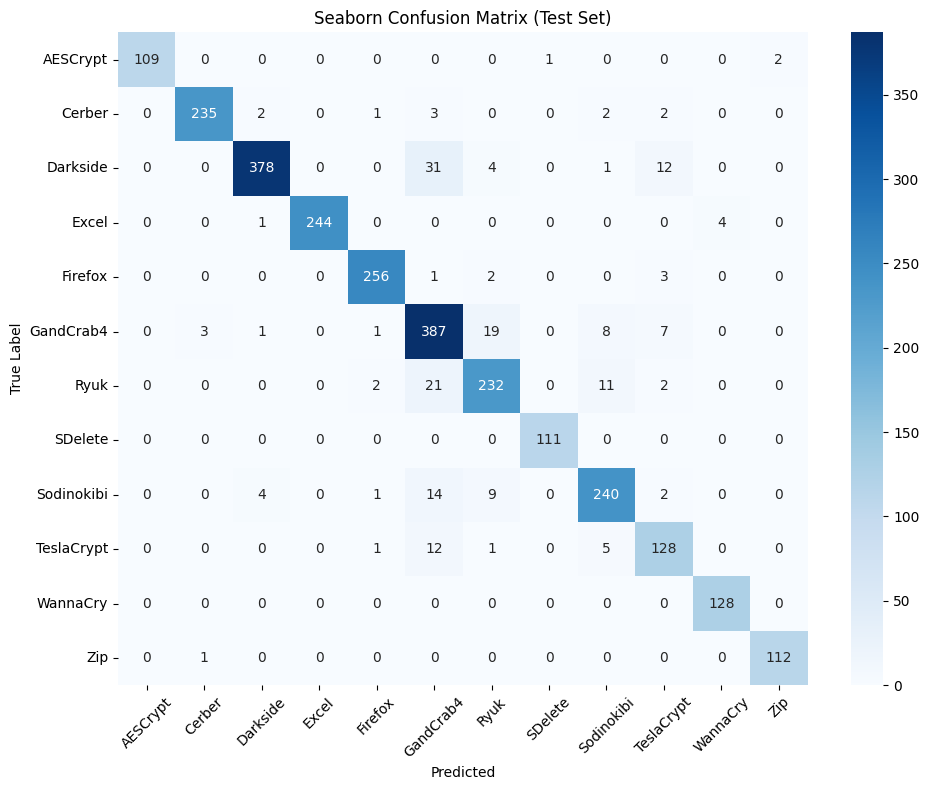

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Rebuild same model architecture
model = StudentCNN(input_length=CHUNK_SIZE, num_classes=len(label_encoder.classes_))
model.load_state_dict(torch.load("best_student_baseline.pth"))
model.to(device)
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for streams, labels in test_loader:
        # Move to device
        streams = [s.to(device) for s in streams]
        labels = labels.to(device)

        outputs = model(streams)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Inverse-transform for reporting
pred_labels_str = label_encoder.inverse_transform(all_preds)
true_labels_str = label_encoder.inverse_transform(all_labels)

# === 5. Classification Report
print("=== 🧪 Final Test Set Classification Report ===")
print(classification_report(true_labels_str, pred_labels_str, digits=4))

# === 6. Seaborn Confusion Matrix
cm = confusion_matrix(true_labels_str, pred_labels_str, labels=label_encoder.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title("Seaborn Confusion Matrix (Test Set)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import time
import os
import psutil
import copy
from thop import profile

# === Profiling functions using clean model copies ===
def get_stream_macs_params(stream):
    dummy_input = torch.randn(1, 1, CHUNK_SIZE)
    stream_copy = copy.deepcopy(stream)
    macs, params = profile(stream_copy, inputs=(dummy_input,), verbose=False)
    return macs, params

def get_linear_macs_params(layer, in_features):
    dummy_input = torch.randn(1, in_features)
    layer_copy = copy.deepcopy(layer)
    macs, params = profile(layer_copy, inputs=(dummy_input,), verbose=False)
    return macs, params

# === Utility functions ===
def get_model_size(model):
    temp_path = "temp_model.pth"
    torch.save(model.state_dict(), temp_path)
    size_mb = os.path.getsize(temp_path) / (1024 ** 2)
    os.remove(temp_path)
    return size_mb

def measure_latency(model, inputs, n_runs=100):
    model.eval()
    with torch.no_grad():
        start = time.time()
        for _ in range(n_runs):
            model(inputs)
        end = time.time()
    return (end - start) / n_runs * 1000

def measure_cpu_usage(model, inputs, duration=2):
    model.eval()
    process = psutil.Process(os.getpid())
    num_cpus = psutil.cpu_count(logical=True)
    _ = process.cpu_percent(interval=None)
    with torch.no_grad():
        start_time = time.time()
        while time.time() - start_time < duration:
            model(inputs)
    total_cpu_percent = process.cpu_percent(interval=None)
    return total_cpu_percent / num_cpus

# === Final evaluation logic ===
def evaluate_full_model(model_class, model_path, *args, **kwargs):
    # 🔁 Create two fresh instances using passed args
    prof_model = model_class(*args, **kwargs)
    prof_model.load_state_dict(torch.load(model_path))
    prof_model.eval()

    clean_model = model_class(*args, **kwargs)
    clean_model.load_state_dict(torch.load(model_path))
    clean_model.eval()

    total_macs, total_params = 0, 0

    # 🔍 Stream MACs
    print("🔍 Stream MAC breakdown:")
    for i in range(8):
        macs_i, params_i = get_stream_macs_params(prof_model.streams[i])
        print(f"  Stream[{i}] MACs: {macs_i}, Params: {params_i}")
        total_macs += macs_i
        total_params += params_i

    # 🔍 FC layers
    print("\n🔍 FC Layer breakdown:")
    macs_fc1, params_fc1 = get_linear_macs_params(prof_model.fc[0], in_features=64)
    print(f"  FC[0] (64→128) MACs: {macs_fc1}, Params: {params_fc1}")
    macs_fc2, params_fc2 = get_linear_macs_params(prof_model.fc[4], in_features=128)
    print(f"  FC[4] (128→classes) MACs: {macs_fc2}, Params: {params_fc2}")
    total_macs += macs_fc1 + macs_fc2
    total_params += params_fc1 + params_fc2

    # 🔍 Projection
    print("\n🔍 Projection Layer:")
    macs_proj, params_proj = get_linear_macs_params(prof_model.proj, in_features=64)
    print(f"  Proj (64→128) MACs: {macs_proj}, Params: {params_proj}")
    total_macs += macs_proj
    total_params += params_proj


    flops = 2 * total_macs
    size_mb = get_model_size(clean_model)

    dummy_inputs = [torch.randn(1, 1, CHUNK_SIZE) for _ in range(8)]
    latency = measure_latency(clean_model, dummy_inputs)
    cpu_usage = measure_cpu_usage(clean_model, dummy_inputs)

    return {
        "Model Size (MB)": round(size_mb, 4),
        "Latency (ms)": round(latency, 3),
        "CPU Usage (%)": round(cpu_usage, 2),
        "Total MACs": int(total_macs),
        "FLOPs": int(flops),
        "Total Params": int(total_params)
    }


# === Usage ===
# You must define your StudentCNN class and load the model first
model = StudentCNN(input_length=CHUNK_SIZE, num_classes=len(label_encoder.classes_))
model.load_state_dict(torch.load("best_student_baseline.pth"))
# Then:
#torch.save(model.state_dict(), "student_model.pth")
stats = evaluate_full_model(StudentCNN, "best_student_baseline.pth", input_length=CHUNK_SIZE, num_classes=len(label_encoder.classes_))
for k, v in stats.items():
    print(f"{k}: {v}")


/tmp/ipykernel_3245880/3242020110.py:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_student_baseline.pth"))
/tmp/ipykernel_3245880

🔍 Stream MAC breakdown:
  Stream[0] MACs: 1864.0, Params: 120.0
  Stream[1] MACs: 1864.0, Params: 120.0
  Stream[2] MACs: 1864.0, Params: 120.0
  Stream[3] MACs: 1864.0, Params: 120.0
  Stream[4] MACs: 1864.0, Params: 120.0
  Stream[5] MACs: 1864.0, Params: 120.0
  Stream[6] MACs: 1864.0, Params: 120.0
  Stream[7] MACs: 1864.0, Params: 120.0

🔍 FC Layer breakdown:
  FC[0] (64→128) MACs: 8192.0, Params: 0
  FC[4] (128→classes) MACs: 1536.0, Params: 0

🔍 Projection Layer:
  Proj (64→128) MACs: 8192.0, Params: 0
Model Size (MB): 0.0867
Latency (ms): 2.31
CPU Usage (%): 35.61
Total MACs: 32832
FLOPs: 65664
Total Params: 960


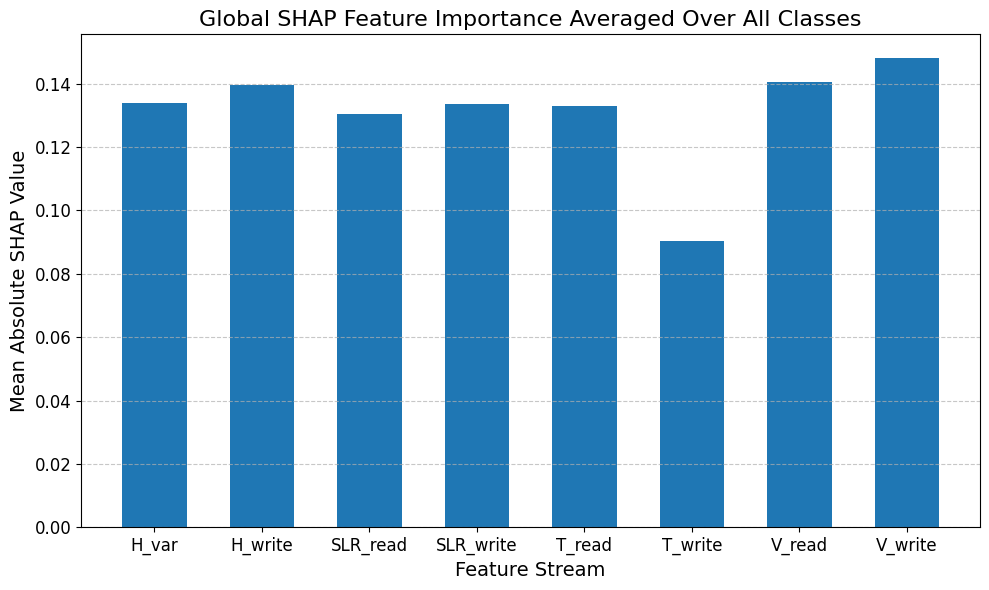

✅ Saved global SHAP bar plot as PNG and PDF.


In [ ]:
import shap
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ===== 1. Load model =====
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== 2. Load data batch =====
streams, labels = next(iter(test_loader))
sample_batch = [s.to(device) for s in streams]

def batch_to_shap_input(batch):
    return torch.cat(batch, dim=1)

shap_input_full = batch_to_shap_input(sample_batch)  # [B,8,T]
shap_input_full.requires_grad = True

# ===== 3. Sample 100 examples randomly =====
torch.manual_seed(42)
np.random.seed(42)

N = shap_input_full.shape[0]
indices = np.random.choice(N, size=100)
background_idx = indices[:30]
test_idx = indices[30:]

background = shap_input_full[background_idx]
test_samples = shap_input_full[test_idx]

# ===== 4. Wrapped model (return full logits) =====
class MultiOutputWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        split = [x[:, i:i+1, :] for i in range(x.size(1))]  # List of 8 [B,1,T]
        return self.model(split)  # [B, num_classes]

wrapped_model = MultiOutputWrapper(model).to(device)
wrapped_model.eval()

# ===== 5. Run GradientExplainer for all outputs =====
explainer = shap.GradientExplainer(wrapped_model, background)
shap_values = explainer.shap_values(test_samples)  # List of [B_test, 8, T] × num_classes

# ===== 6. Global average over all classes =====
num_classes = len(shap_values)
num_streams = len(shap_values[0])  # Should be 8
avg_importance = []

for i in range(num_streams):
    stream_total = 0.0
    for c in range(num_classes):
        stream_shap = shap_values[c][:, i, :]  # [B, T]
        stream_total += np.abs(stream_shap).mean()
    avg_importance.append(stream_total / num_classes)

# ===== 7. Plot + Save Figure =====
stream_names = ["T_write", "T_read", "V_write", "V_read", "H_write", "H_var", "SLR_write", "SLR_read"]

# Sort and plot
importance_df = pd.DataFrame({'Feature': stream_names, 'Importance': avg_importance})
importance_df = importance_df.sort_values('Feature')  # Force fixed order

plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'], width=0.6)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Mean Absolute SHAP Value", fontsize=14)
plt.xlabel("Feature Stream", fontsize=14)
plt.title("Global SHAP Feature Importance Averaged Over All Classes", fontsize=16)
plt.tight_layout()

plt.savefig("global_avg_shap_per_stream.png", dpi=300)
plt.savefig("global_avg_shap_per_stream.pdf")
plt.show()

print("✅ Saved global SHAP bar plot as PNG and PDF.")


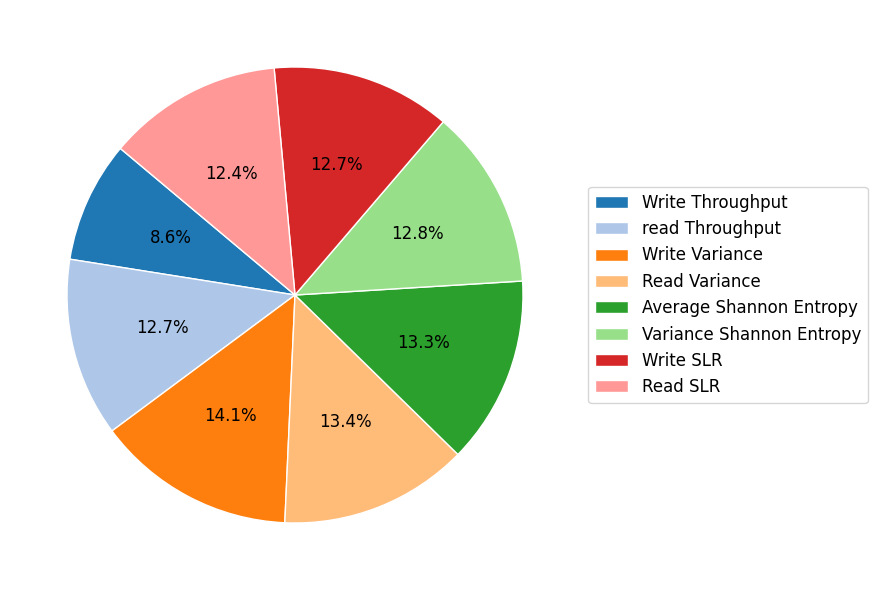

✅ Pie chart with external legend saved as PNG and PDF.


In [ ]:
import matplotlib.pyplot as plt

# ===== Pie Chart of SHAP Importance with External Legend =====
plt.figure(figsize=(10, 6))
stream_names = ["Write Throughput", "read Throughput", "Write Variance", "Read Variance", "Average Shannon Entropy", "Variance Shannon Entropy",
                 "Write SLR", "Read SLR"]

# Sort and plot
importance_df = pd.DataFrame({'Feature': stream_names, 'Importance': avg_importance})
# Keep original order based on stream_names
importance_df = pd.DataFrame({'Feature': stream_names, 'Importance': avg_importance})
colors = plt.cm.tab20.colors  # or any color palette you prefer

# Create pie chart without labels
wedges, texts, autotexts = plt.pie(
    importance_df['Importance'], 
    autopct='%1.1f%%',
    startangle=140,
    colors=colors[:len(importance_df)],
    textprops={'fontsize': 12},
    wedgeprops={'edgecolor': 'white'}
)

# Add legend outside the pie
plt.legend(
    wedges, 
    importance_df['Feature'], 
    # title="Feature Streams",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=12,
    title_fontsize=14
)

# plt.title('Global SHAP Feature Importance per Stream', fontsize=16)
plt.tight_layout()

# Save the plot
plt.savefig("global_avg_shap_pie_with_legend.png", dpi=300, bbox_inches="tight")
plt.savefig("global_avg_shap_pie_with_legend.pdf", bbox_inches="tight")
plt.show()

print("✅ Pie chart with external legend saved as PNG and PDF.")



shap_values_stack.shape: (12, 70, 8, 16)
shap_values_avg_time.shape: (12, 70, 8)
shap_vals_flat.shape: (70, 8)
features_flat.shape: (70, 8)


/tmp/ipykernel_3245880/1431495212.py:24: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


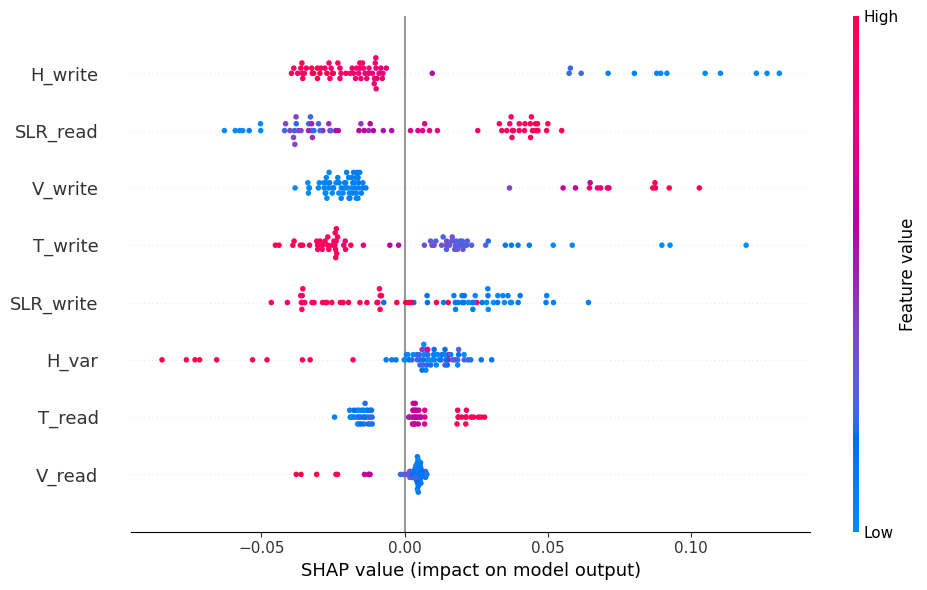

In [ ]:
# ===== 0. First fix shap_values =====
# shap_values: [70, 8, 51, 12]
shap_values_split = [shap_values[..., i] for i in range(12)]  # List of 12 arrays [70, 8, 51]

# ===== 1. Stack over classes =====
shap_values_stack = np.stack(shap_values_split, axis=0)  # [12, 70, 8, 51]
print("shap_values_stack.shape:", shap_values_stack.shape)  # Should now be (12, 70, 8, 51)

# ===== 2. Average over time (axis=3)
shap_values_avg_time = shap_values_stack.mean(axis=3)  # [12, 70, 8]
print("shap_values_avg_time.shape:", shap_values_avg_time.shape)  # (12, 70, 8)

# ===== 3. Average over classes (axis=0)
shap_vals_flat = shap_values_avg_time.mean(axis=0)  # [70, 8]
print("shap_vals_flat.shape:", shap_vals_flat.shape)  # ✅ (70, 8)

# ===== 4. Feature values (inputs)
features_flat = test_samples.detach().cpu().numpy().mean(axis=2)  # [70, 8]
print("features_flat.shape:", features_flat.shape)  # ✅ (70, 8)

# ===== 5. Plot
stream_names = ["T_write", "T_read", "V_write", "V_read", "H_write", "H_var", "SLR_write", "SLR_read"]

shap.summary_plot(
    shap_vals_flat,
    features_flat,
    feature_names=stream_names,
    plot_type="dot",
    max_display=8,
    show=False
)

plt.gcf().set_size_inches(10, 6)
plt.tight_layout()
plt.savefig("shap_beeswarm_streams.png", dpi=300, bbox_inches="tight")
plt.savefig("shap_beeswarm_streams.pdf", bbox_inches="tight")
plt.show()


In [39]:
import os
import torch
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader

# === CONFIGURATION ===
detection_times = [30, 45, 60]
window_sizes = [10, 15, 20]
NUM_FEATURES = 5
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_dir = "/home/HardDisk/Satang/thesis_proj/"
base_teacher_dir = os.path.join(base_dir, "Deep_Learning", "multi_cnn_5", "teacher")
student_kd_dir = os.path.join(base_dir, "Deep_Learning", "multi_cnn_5", "student")
student_baseline_dir = os.path.join(base_dir, "Deep_Learning", "multi_cnn_5", "baseline_student")
csv_output_path = os.path.join(base_dir, "Deep_Learning", "multi_cnn_5", "results", "model_eval_summary.csv")
os.makedirs(os.path.dirname(csv_output_path), exist_ok=True)

results = []

# === Evaluation Function ===
def evaluate_and_log(model, model_path, test_loader, label_encoder, T_d, T_w, model_type, results_list):
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for streams, labels in test_loader:
            streams = [s.to(DEVICE) for s in streams]
            labels = labels.to(DEVICE)
            outputs = model(streams)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    report = classification_report(all_labels, all_preds, target_names=label_encoder.classes_, output_dict=True)
    acc = accuracy_score(all_labels, all_preds)

    results_list.append({
        "Td": T_d,
        "Tw": T_w,
        "T_len": T_d - T_w + 1,
        "Model": model_type,
        "Accuracy": round(acc, 4),
        "Precision_macro": round(report["macro avg"]["precision"], 4),
        "Recall_macro": round(report["macro avg"]["recall"], 4),
        "F1_macro": round(report["macro avg"]["f1-score"], 4),
        "F1_weighted": round(report["weighted avg"]["f1-score"], 4),
    })

# === MAIN LOOP ===
for T_d in detection_times:
    for T_w in window_sizes:
        T_len = T_d - T_w + 1
        expected_shape = (T_len, NUM_FEATURES)
        folder_name = f"X_csv_split_{T_len}"
        test_path = os.path.join(base_dir, f"New_{T_d}", f"{T_w}", "split_tws_5", folder_name, "test")

        # === Load Test Data ===
        X_test_raw, y_test_raw = load_split_from_folder(test_path, expected_shape)
        label_encoder = LabelEncoder()
        label_encoder.fit(y_test_raw)

        test_dataset = MultiStreamDataset(X_test_raw, y_test_raw, label_encoder, augment=False)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

        # === Teacher ===
        teacher_path = os.path.join(base_teacher_dir, f"teacher_Td{T_d}_Tw{T_w}.pth")
        teacher_model = MultiStreamCNN(input_length=T_len, num_classes=len(label_encoder.classes_))
        evaluate_and_log(teacher_model, teacher_path, test_loader, label_encoder, T_d, T_w, "Teacher", results)

        # === Student (KD) ===
        student_kd_path = os.path.join(student_kd_dir, f"student_KD_Td{T_d}_Tw{T_w}.pth")
        student_kd_model = StudentCNN(input_length=T_len, num_classes=len(label_encoder.classes_))
        evaluate_and_log(student_kd_model, student_kd_path, test_loader, label_encoder, T_d, T_w, "Student_KD", results)

        # === Student (Baseline) ===
        student_baseline_path = os.path.join(student_baseline_dir, f"student_baseline_Td{T_d}_Tw{T_w}.pth")
        student_baseline_model = StudentCNN(input_length=T_len, num_classes=len(label_encoder.classes_))
        evaluate_and_log(student_baseline_model, student_baseline_path, test_loader, label_encoder, T_d, T_w, "Student_Baseline", results)

# === Save Results ===
df_results = pd.DataFrame(results)
df_results.to_csv(csv_output_path, index=False)
print(f"\n✅ All evaluation results saved to: {csv_output_path}")


/tmp/ipykernel_1945517/4235439759.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVICE))
/tmp/ipykernel_1945


✅ All evaluation results saved to: /home/HardDisk/Satang/thesis_proj/Deep_Learning/multi_cnn_5/results/model_eval_summary.csv
